## Install libraries

In [ ]:
!pip install brminer
!pip install python-weka-wrapper3
!pip install scikit-posthocs
!pip install pyod
!pip install liac-arff

     |████████████████████████████████| 12.9 MB 110 kB/s 
     |████████████████████████████████| 1.3 MB 26.0 MB/s 
  Created wheel for python-weka-wrapper3: filename=python_weka_wrapper3-0.2.3-py3-none-any.whl size=11540516 sha256=7ac16522cbf7c95315a5735fa02406b8ef333a3d04ae798df61ef1c7afd40ea6
  Stored in directory: /root/.cache/pip/wheels/95/b9/7e/ea917497d6769b8b5a025c7509ef7f1c4e4da4d53621aef3e6
  Created wheel for javabridge: filename=javabridge-1.0.19-cp37-cp37m-linux_x86_64.whl size=1636660 sha256=5a930c53d58fe77d6387b482dd334510ce5f7b09a62d41f4cc3db484b676f8d6
  Stored in directory: /root/.cache/pip/wheels/8b/5e/7f/e1dd610613dcde4a4ed2974b4208ba90247a2dfc9add216c59
Successfully built python-weka-wrapper3 javabridge
     |████████████████████████████████| 43 kB 1.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-posthocs: filename=scikit_posthocs-0.6.7-py3-none-any.whl

## Git Clone

In [ ]:
!git clone https://github.com/ebucheli/DT-Autoencoder.git
!git clone https://github.com/caaxgave/Uns_AnomalyDetAlg
!cd /content
%cd /content/Uns_AnomalyDetAlg
!unzip Unsupervised_Anomaly_Detection.zip
!unzip Datasets.zip
%cd ..

Cloning into 'DT-Autoencoder'...
remote: Enumerating objects: 148, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 148 (delta 84), reused 88 (delta 33), pack-reused 0
Receiving objects: 100% (148/148), 418.44 KiB | 22.02 MiB/s, done.
Resolving deltas: 100% (84/84), done.
Cloning into 'Uns_AnomalyDetAlg'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 40 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (40/40), done.
/content/Uns_AnomalyDetAlg
Archive:  Unsupervised_Anomaly_Detection.zip
   creating: Unsupervised_Anomaly_Detection/
   creating: Unsupervised_Anomaly_Detection/abalone-17_vs_7-8-9-10/
  inflating: Unsupervised_Anomaly_Detection/abalone-17_vs_7-8-9-10/abalone-17_vs_7-8-9-10-5-1tra.dat  
  inflating: Unsupervised_Anomaly_Detection/abalone-17_vs_7-8-9-10/abalone-17_vs_7-8-9-10-5-1tst.d

## File modified

In [ ]:
import os
os.rename('/content/DT-Autoencoder', '/content/DTAE')

In [ ]:
%%file /content/DTAE/dtae.py

import argparse
import json

import numpy as np
from scipy.io import arff

from weka.classifiers import Classifier
from weka.core.converters import Loader
from weka.filters import Filter

from copy import deepcopy

from DTAE.classifier import train_trees, get_initial_weights,reLu,neuron_l1,train, test
from DTAE.data_loader import load_data, make_partition

def DTAE(train_path, test_path, rand_init='store_true'):
    try:
        data_train, attributes = load_data(train_path)
        N_train = data_train.num_instances
        attributes = attributes[:-1]

        remove = Filter(classname='weka.filters.unsupervised.attribute.Remove',
                        options = ['-R','last'])
        remove.inputformat(data_train)
        data_train = remove.filter(data_train)

        doit = False
        to_del = []

        for i in range(data_train.num_attributes):
            if len(data_train.attribute(i).values) <= 1:
                to_del.append(i+1)
                doit = True

        if doit:
            to_del_str = ','.join(str(e) for e in to_del)
            remove_const = Filter(classname='weka.filters.unsupervised.attribute.Remove',
                                  options = ['-R',to_del_str])
            remove_const.inputformat(data_train)
            data_train = remove_const.filter(data_train)

        attributes = [f.name for f in data_train.attributes()]
        m_train = data_train.num_attributes

        #print('\n\n############ Training Decision Trees ############\n\n')

        clfs,evls,dt_y_hat,unused_attributes = train_trees(data_train,attributes)

        w2_init,w1_init,b1_init = get_initial_weights(data_train,
                                                      clfs,
                                                      evls,
                                                      attributes,
                                                      dt_y_hat,
                                                      unused_attributes)

        if rand_init == True:

            w1_init = []
            for i in range(m_train):
                len_values = len(data_train.attribute(i).values)
                w1_init.append(np.random.randn(len_values))

        data_test,attributes_test = load_data(test_path)
        data_test.class_is_last()
        N_test = data_test.num_instances

        doit = False
        to_del = []

        for i in range(data_test.num_attributes):
            if len(data_test.attribute(i).values) <= 1:
                to_del.append(i+1)
                doit = True

        if doit:
            print('Deleting Constant Attributes {}'.format(to_del))
            to_del_str = ','.join(str(e) for e in to_del)
            remove_const = Filter(classname='weka.filters.unsupervised.attribute.Remove',
                                  options = ['-R',to_del_str])
            remove_const.inputformat(data_test)
            data_test = remove_const.filter(data_test)

        attributes_test = [f.name for f in data_test.attributes()]

        res2,my_score2 = test(data_test,
                              N_test,
                              attributes_test,
                              clfs,
                              w1_init,
                              b1_init,
                              w2_init,
                              unused_attributes,
                              verbose = 0)

        res = res2
        my_score = my_score2
		
        dict_res = {'AUC_trained':my_score,
                    'scores_trained':res.tolist(),
                    'AUC_initial':my_score2,
                    'scores_initial':res2.tolist()}

    finally:
        return my_score, res
        #jvm.stop()

Writing /content/DTAE/dtae.py


In [ ]:
%%file /content/DTAE/classifier.py

import numpy as np
from sklearn.metrics import recall_score, roc_auc_score, average_precision_score

from weka.core import jvm
from weka.classifiers import Classifier, Evaluation
from weka.core.classes import Random
from weka.core.converters import Loader
from weka.filters import Filter

from copy import deepcopy


def train_trees(data,attributes):

    clfs = []
    evls = []
    dt_y_hat = []

    unused_attributes = []

    for i,att in enumerate(attributes):

        data.class_index = i

        count_non_nans = np.count_nonzero(~np.isnan(data.values(i)))

        if count_non_nans<5:

            unused_attributes.append(i)
            print('Not using attribute {}, only {} real values\n\n'.format(att,count_non_nans))
            clfs.append(None)
            evls.append(None)
            dt_y_hat.append(None)
            continue

        this_clf = Classifier(classname='weka.classifiers.trees.J48',options = ['-U','-B','-M','2'])
        this_clf.build_classifier(data)

        this_evl = Evaluation(data)
        this_evl.crossvalidate_model(this_clf,data,5,Random(1))

        dt_y_hat.append(this_clf.distributions_for_instances(data))
        clfs.append(this_clf)
        evls.append(this_evl)

    return clfs,evls,dt_y_hat,unused_attributes

def get_initial_weights(data,clfs,evls,attributes,dt_y_hat,unused_attributes):
    w1_init = []
    w2_init = []

    for i,att in enumerate(attributes):
        if i in unused_attributes:
            w1_init.append(None)
            w2_init.append(None)
            continue

        #print('Attribute: {}\n'.format(att))

        rocs = []

        att_values = data.attribute(i).values
        len_att_values = len(att_values)

        temp_w = np.zeros(len_att_values)

        num_nans = 0

        for j in range(len_att_values):

            this_roc = evls[i].area_under_roc(j)

            if not np.isnan(this_roc):
                rocs.append(this_roc)
                #print('\tNAN at value {}'.format(data.attribute(i).values[j]))
            #else:
            #    rocs.append(this_roc)

            temp = evls[i].recall(j)

            if np.isnan(temp):
                temp = 0

            temp_w[j] = temp

        if not rocs:
            rocs.append(1)

        #print('\tAverage AUC: {:0.4f}\n'.format(np.mean(rocs)))

        w1_init.append(temp_w)
        w2_init.append(np.mean(rocs))

    bias_init = np.zeros((len(w2_init)))

    return w2_init,w1_init,bias_init

def reLu(x):
    if x > 0:
	    return x
    return 0

def neuron_l1(x_prime,weights,bias,indxs):

    if x_prime is None:
        return None

    my_res = np.zeros((len(x_prime)))

    for i,this_x_prime in enumerate(x_prime):

        if indxs[i] >= len(weights):
            indxs[i] -= 1
        this_x_wrong = np.delete(this_x_prime,indxs[i])
        w_wrong = np.delete(weights,indxs[i])

        my_res[i] = this_x_prime[indxs[i]]*weights[indxs[i]]-np.mean(this_x_wrong*w_wrong)
		
    return my_res

def get_batches(dt_y_hat,batch_size=32):

    N = len(dt_y_hat)

    if N < batch_size:
        batch_size = N

    reps = N // batch_size

    batches = []
    batch_startend = []

    for i in range(reps):
        start = i*batch_size
        end = start+batch_size
        batches.append(dt_y_hat[start:end])
        batch_startend.append([start,end])
    if end < N:
        start = end
        end = N
        batches.append(dt_y_hat[start:end])
        batch_startend.append([start,end])

    return batches,batch_startend

def train(w1_init,b1_init,lr,epochs,N,data,attributes,dt_y_hat,batch_size,unused_attributes):

    w1 = deepcopy(w1_init)
    b1 = deepcopy(b1_init)

    losses = []
    accs = []

    for epoch in range(epochs):

        hl1_this = np.zeros((N,len(dt_y_hat)))

        for j,x_prime in enumerate(dt_y_hat):
            if j in unused_attributes:
                continue

            batches,batch_startend = get_batches(x_prime,batch_size=batch_size)
            num_labels = np.array(data.values(j),dtype = np.int64)

            for batch_ind, x_prime_batch in enumerate(batches):
                x_prime_prime_batch = x_prime_batch*w1[j]
                start,end = batch_startend[batch_ind]
                batch_num_labels = num_labels[start:end]

                for dani,f in enumerate(batch_num_labels):
                    if f < 0:
                        batch_num_labels[dani] = 0

                for k in np.unique(batch_num_labels):

                    if np.isnan(k):
                        k = 0

                    indices = np.where(batch_num_labels==k)
                    this_probs = x_prime_batch[indices]
                    x_prime_this = x_prime_batch[indices]
                    x_prime_prime_this = x_prime_prime_batch[indices]

                    a = neuron_l1(x_prime_this,w1[j],b1[j],np.ones((len(x_prime_this)),dtype = int)*k)

                    grad_wj = np.dot(a*(1-a),x_prime_this[:,k])
                    grad_bias = np.mean(a*(1-a))


                    w1[j][k] = w1[j][k] + lr*grad_wj
                    b1[j] = b1[j] + lr*grad_bias

        for j,x_prime in enumerate(dt_y_hat):

            num_labels = np.array(data.values(j),dtype = np.int64)

            for dani,f in enumerate(num_labels):
                if f < 0:
                    num_labels[dani] = 0

            hl1_this[:,j] = neuron_l1(x_prime,w1[j],b1[j],num_labels)

        this_loss = np.mean(hl1_this,axis = 0)
        if epoch % 10 == 0 or epoch == epochs-1:
            print('Epoch {}:'.format(epoch+1))
            for m, loss_part in enumerate(this_loss):
                print('\tAttribute {} Loss: {:0.4f}'.format(m+1,loss_part))
    return w1,b1

def test(data,N,attributes,clfs,w1,b1,w2,unused_attributes,verbose = 1):

    remove = Filter(classname='weka.filters.unsupervised.attribute.Remove',
                    options = ['-R','last'])
    remove.inputformat(data)

    data_noclass = remove.filter(data)

    dt_all = []

    for i,att in enumerate(attributes[:-1]):

        if i in unused_attributes:
            dt_all.append(None)
            continue

        data_noclass.class_index = i
        dt_all.append(clfs[i].distributions_for_instances(data_noclass))

    hl1_this_all = np.zeros((N,len(attributes[:-1])))
    preds = []

    my_div = np.zeros((N,))+len(w2)-len(unused_attributes)

    for j,x_prime in enumerate(dt_all):

        if j in unused_attributes:
            continue

        num_labels = np.array(data_noclass.values(j),dtype = np.int32)

        missing_vals = []

        doit = False
        for dani,f in enumerate(num_labels):

            if f < 0:
                doit = True
                missing_vals.append(dani)
                num_labels[dani] = 0

        if doit:
            if verbose:
                print('There were missing values on instances {} of attribute {}'.format(missing_vals,attributes[j]))

        this_preds = neuron_l1(x_prime,w1[j],b1[j],num_labels)

        for miss in missing_vals:
            this_preds[miss] = 0
            my_div[miss] -= 1
        preds.append(this_preds)

    w2_temp = np.delete(w2,unused_attributes)
    res = np.dot(np.array(preds).T,w2_temp)

    class_index_data = data.class_index

    y = data.values(class_index_data)
    y = np.abs(y-1)
    my_score = roc_auc_score(y,res)
    precision = average_precision_score(y, res)

    return precision, my_score

Overwriting /content/DTAE/classifier.py


## Import Libraries

In [1]:
from sklearn.preprocessing import KBinsDiscretizer
from io import StringIO
from scipy.io import arff
import arff as liacArff
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture
from sklearn.covariance import EllipticEnvelope
import brminer as BRM
from pyod.models.copod import COPOD
from sklearn.metrics import roc_auc_score
from scipy import stats

from DTAE.dtae import DTAE

import scikit_posthocs as sp

from sklearn.metrics import average_precision_score
from sklearn.preprocessing import OneHotEncoder

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Functions

In [2]:
def importdata(path, bins, algorithm):
  pathTra = path + "-5-1tra.dat"
  pathTst = path + "-5-1tst.dat"

  fTrain = readFile(pathTra)
  dfTrain = createDf(fTrain)

  fTest = readFile(pathTst)
  dfTest = createDf(fTest)
  #Discretize Data
  discretizedTra, discretizedTst = discretize(dfTrain, dfTest, bins, algorithm)
  createArff(discretizedTra, discretizedTst, path)
  
  return discretizedTra, discretizedTst


def importdata_uns(path, bins, algorithm):
  pathTra = path + "-5-1tra.dat"
  pathTst = path + "-5-1tst.dat"

  fTrain = readFile(pathTra)
  dfTrain = createDf(fTrain)

  fTest = readFile(pathTst)
  dfTest = createDf(fTest)
  #Discretize Data
  discretized_uns_tra, discretized_uns_tst = discretize_uns(dfTrain, dfTest, bins, algorithm)
  
  createArff(discretized_uns_tra, discretized_uns_tst, path)
  
  return discretized_uns_tra, discretized_uns_tst

def readFile(path):
  with open(path, "r") as f:
    lines = f.readlines()
    for i in range(len(lines)):
      if "@inputs" in lines[i]:
        lines.pop(i)
        next
      if '@input' in lines[i]:
        lines.pop(i)
        next
      if "@outputs" in lines[i]:
        lines.pop(i)
        break
      if '@output' in lines[i]:
        lines.pop(i)
        break
        
  rawData = ''.join(lines)
  return StringIO(rawData)


def createDf(fileArff):
  data = arff.loadarff(fileArff)
  df = pd.DataFrame(data[0])
  #Decode data
  str_df = df.select_dtypes([np.object]) 
  str_df = str_df.stack().str.decode('utf-8').unstack()
  df[str_df.columns] = str_df

  return df

def filterData(df):
  newDf = df.copy()
  values, counts = np.unique(df.values[:, -1], return_counts=True)
  if counts[0] > counts[1]:
    if 'Class' in newDf.columns: 
      newDf['Class'] = values[0]
    else:
      newDf['class'] = values[0]
  else:
    if 'Class' in newDf.columns: 
      newDf['Class'] = values[1]
    else:
      newDf['class'] = values[1]
  return newDf

def createArff(dfTrain, dfTest, path):
  allData = pd.concat([dfTrain, dfTest], ignore_index=True, sort =False, axis=0)
  attributes = [(c, allData[c].unique().astype(str).tolist()) for c in allData.columns.values]
  #trainFiltered = filterData(dfTrain)
  #dataTra = [trainFiltered.loc[i].values.tolist() for i in range(trainFiltered.shape[0])]
  dataTra = [dfTrain.loc[i].values.tolist() for i in range(dfTrain.shape[0])]
  dataTst = [dfTest.loc[i].values.tolist() for i in range(dfTest.shape[0])] #[dfTest.loc[i].values.tolist() for i in range(dfTest.shape[0])]
  arff_dicTra = {
      'attributes': attributes,
      'data': dataTra,
      'relation': 'TrainData',
      'description': ''
  }
  arff_dicTst = {
      'attributes': attributes,
      'data': dataTst,
      'relation': 'TestData',
      'description': ''
  }
  trainPath = path + "-5-1tra.arff"
  testPath = path + "-5-1tst.arff"
  print(trainPath)
  with open(trainPath, "w", encoding="utf8") as f:
    liacArff.dump(arff_dicTra, f)
  print(testPath)
  with open(testPath, "w", encoding="utf8") as f:
    liacArff.dump(arff_dicTst, f)

In [3]:
def discretize(dfTrain, dfTest, bins, algorithm):
  dfTra = dfTrain.copy()
  dfTst = dfTest.copy()
  objInTrain = len(dfTra)
  allData = pd.concat([dfTra, dfTst], ignore_index=True, sort =False, axis=0)
  AllDataContinuous = allData.select_dtypes(exclude=['object'])
  numCols = AllDataContinuous.columns
  
  KBin = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy=algorithm)
  if dfTra.select_dtypes(exclude=['object']).shape[1] > 0:
    dfTra[numCols] = KBin.fit_transform(dfTra.select_dtypes(exclude=['object']).values) # AllDataContinuous.values)
    dfTst[numCols] = KBin.transform(dfTst.select_dtypes(exclude=['object']).values)


  return filterData(dfTra), dfTst


def discretize_uns(dfTrain, dfTest, bins, algorithm):
  dfTra = dfTrain.copy()
  dfTst = dfTest.copy()
  objInTrain = len(dfTra)
  allData = pd.concat([dfTra, dfTst], ignore_index=True, sort =False, axis=0)
  AllDataContinuous = allData.select_dtypes(exclude=['object'])
  numCols = AllDataContinuous.columns
  
  KBin = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy=algorithm)
  if dfTra.select_dtypes(exclude=['object']).shape[1] > 0:
    allData[numCols] = KBin.fit_transform(AllDataContinuous.values)
    

  return filterData(allData), allData



In [4]:
def iterateModels(X_train, X_test, y_train, y_test, arff_path):
  models = [BRM.BRM(), GaussianMixture(), IsolationForest(), EllipticEnvelope()]
  local_arr_auc = []
  avr_pre_list = []
  for model in models:
      model.fit(X_train, y_train)
      # Operational Phase 
      y_pred = model.score_samples(X_test)
      auc = roc_auc_score(y_test,  y_pred)
      local_arr_auc.append(1 - auc if auc < 0.5 else auc)
      avr_pre_list.append(average_precision_score(y_test,  y_pred, pos_label='negative'))
      #print(f'Testing AUC: {auc if auc > .5 else 1 - auc}')
  AUC, Precision = DTAE(arff_path + '-5-1tra.arff', arff_path + '-5-1tst.arff')
  local_arr_auc.append(1 - AUC if AUC < 0.5 else AUC)
  avr_pre_list.append(Precision)
  return local_arr_auc + avr_pre_list


# Function to split target from data 
def splitdataset(train, test): 
    ohe = OneHotEncoder(sparse=True)
    objInTrain = len(train)

    allData = pd.concat([train, test], ignore_index=True, sort =False, axis=0)
    AllDataWihoutClass = allData.iloc[:, :-1]
    AllDataWihoutClassOnlyNominals = AllDataWihoutClass.select_dtypes(include=['object'])
    AllDataWihoutClassNoNominals = AllDataWihoutClass.select_dtypes(exclude=['object'])

    encAllDataWihoutClassNominals = ohe.fit_transform(AllDataWihoutClassOnlyNominals)
    encAllDataWihoutClassNominalsToPanda = pd.DataFrame(encAllDataWihoutClassNominals.toarray())
    
    if AllDataWihoutClassOnlyNominals.shape[1] > 0:
      codAllDataAgain = pd.concat([encAllDataWihoutClassNominalsToPanda, AllDataWihoutClassNoNominals], ignore_index=True, sort =False, axis=1)
    else:
      codAllDataAgain = AllDataWihoutClass

    # Seperating the target variable 
    X_train = codAllDataAgain[:objInTrain]
    y_train = train.values[:, -1]

    X_test = codAllDataAgain[objInTrain:]
    y_test = test.values[:, -1]
    
    return X_train, X_test, y_train, y_test


def avrRank(dataset):
  data_array = dataset.values
  positions = []
  for row in data_array:
    pos = np.argsort(row)[::-1] + 1
    positions.append(pos)

  return np.mean(positions, axis=0)


def main(bins, algorithm, supervised):
  excluded = ["vehicle3", "kr-vs-k-zero-one_vs_draw", "kr-vs-k-zero_vs_fifteen", "vehicle2", "lymphography-normal-fibrosis", "car-good",
              "kr-vs-k-three_vs_eleven", "zoo-3", "shuttle-2_vs_5", "car-vgood", "vehicle0", "kr-vs-k-one_vs_fifteen", "led7digit-0-2-4-5-6-7-8-9_vs_1",
              "segment0"]
  directory = "/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection"
  all_auc = list()
  count = 1
  for dirName, subdirList, fileList in os.walk(directory):
    if len(fileList) > 0: 
      arr_auc = list()
      dirList = dirName.split("/")  #Carpeta dirName + "/" + dirList[-1]
      arr_auc.append(dirList[-1])
      path = dirName + '/' + dirList[-1]

      if supervised:
        train, test = importdata(path, bins, algorithm)
      else:
        train, test = importdata_uns(path, bins, algorithm)
      X_train, X_test, y_train, y_test = splitdataset(train, test)
      print(dirList[-1])
      if dirList[-1] not in excluded:
        print("Dataset number: {}".format(count))
        result = iterateModels(X_train, X_test, y_train, y_test, path)
        dataset_auc = list()
        dataset_auc.append(dirList[-1])
        dataset_auc.extend(result)
        all_auc.append(dataset_auc)
      else:
        continue
      if count == 30:
        break
      count += 1
  colNames = ['Dataset', 'BRM_auc', 'GMM_auc', 'IsoF_auc', 'Elliptic_auc', 'DTAE_auc', 'BRM_avr_pre', 'GMM_avr_pre', 'IsoF_avr_pre', 'Elliptic_avr_pre', 'DTAE_avr_pre']
  return pd.DataFrame(all_auc, columns=colNames)
      # Training

### classifier.py modified for unsupervised classifier

## Main

Start Java Virtual Machine

In [ ]:
from weka.core import jvm
jvm.start()

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/usr/local/lib/python3.7/dist-packages/javabridge/jars/rhino-1.7R4.jar', '/usr/local/lib/python3.7/dist-packages/javabridge/jars/runnablequeue.jar', '/usr/local/lib/python3.7/dist-packages/javabridge/jars/cpython.jar', '/usr/local/lib/python3.7/dist-packages/weka/lib/weka.jar', '/usr/local/lib/python3.7/dist-packages/weka/lib/python-weka-wrapper.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support disabled


In [ ]:
bins = [3,5,7]
algorithms = ['kmeans', 'quantile', 'uniform']
for alg in algorithms:
  for bin in bins:
    dataframe_csv = main(bin, alg)
    dataframe_csv.to_csv('Discretize_{}_{}_bins.csv'.format(alg,bin))

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle3/vehicle3-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle3/vehicle3-5-1tst.arff
vehicle3
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone19/abalone19-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone19/abalone19-5-1tst.arff
abalone19
Dataset number: 1


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-63.575771819404189 > -129.096104697306998). You may want to try with a higher value of support_fraction (current value: 0.502).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-2_vs_8/yeast-2_vs_8-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-2_vs_8/yeast-2_vs_8-5-1tst.arff
yeast-2_vs_8
Dataset number: 2


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-3_vs_5/winequality-red-3_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-3_vs_5/winequality-red-3_vs_5-5-1tst.arff
winequality-red-3_vs_5
Dataset number: 3


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-white-3-9_vs_5/winequality-white-3-9_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-white-3-9_vs_5/winequality-white-3-9_vs_5-5-1tst.arff
winequality-white-3-9_vs_5
Dataset number: 4


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-6_vs_5/glass-0-6_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-6_vs_5/glass-0-6_vs_5-5-1tst.arff
glass-0-6_vs_5
Dataset number: 5


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero-one_vs_draw/kr-vs-k-zero-one_vs_draw-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero-one_vs_draw/kr-vs-k-zero-one_vs_draw-5-1tst.arff
kr-vs-k-zero-one_vs_draw
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/wisconsinImb/wisconsinImb-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/wisconsinImb/wisconsinImb-5-1tst.arff
wisconsinImb
Dataset number: 6


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_cente

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/led7digit-0-2-4-5-6-7-8-9_vs_1/led7digit-0-2-4-5-6-7-8-9_vs_1-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/led7digit-0-2-4-5-6-7-8-9_vs_1/led7digit-0-2-4-5-6-7-8-9_vs_1-5-1tst.arff
led7digit-0-2-4-5-6-7-8-9_vs_1
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8-9_vs_6/poker-8-9_vs_6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8-9_vs_6/poker-8-9_vs_6-5-1tst.arff
poker-8-9_vs_6
Dataset number: 7


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6-7/winequality-red-8_vs_6-7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6-7/winequality-red-8_vs_6-7-5-1tst.arff
winequality-red-8_vs_6-7
Dataset number: 8


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero_vs_fifteen/kr-vs-k-zero_vs_fifteen-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero_vs_fifteen/kr-vs-k-zero_vs_fifteen-5-1tst.arff
kr-vs-k-zero_vs_fifteen
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass1/glass1-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass1/glass1-5-1tst.arff
glass1
Dataset number: 9


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-1-4-6_vs_2/glass-0-1-4-6_vs_2-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-1-4-6_vs_2/glass-0-1-4-6_vs_2-5-1tst.arff
glass-0-1-4-6_vs_2
Dataset number: 10


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle2/vehicle2-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle2/vehicle2-5-1tst.arff
vehicle2
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6/winequality-red-8_vs_6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6/winequality-red-8_vs_6-5-1tst.arff
winequality-red-8_vs_6
Dataset number: 11


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/lymphography-normal-fibrosis/lymphography-normal-fibrosis-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/lymphography-normal-fibrosis/lymphography-normal-fibrosis-5-1tst.arff
lymphography-normal-fibrosis
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-21_vs_8/abalone-21_vs_8-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-21_vs_8/abalone-21_vs_8-5-1tst.arff
abalone-21_vs_8
Dataset number: 12
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-good/car-good-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-good/car-good-5-1tst.arff
car-good
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-2-3-4_vs_5/ecoli-0-2-3-4_vs_5-5-1tra.arff


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:201: UserWarning: Feature 3 is constant and will be replaced with 0.
  "Feature %d is constant and will be replaced with 0." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-2-3-4_vs_5/ecoli-0-2-3-4_vs_5-5-1tst.arff
ecoli-0-2-3-4_vs_5
Dataset number: 13


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [4]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass0/glass0-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass0/glass0-5-1tst.arff
glass0
Dataset number: 14


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1-2-8-9_vs_7/yeast-1-2-8-9_vs_7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1-2-8-9_vs_7/yeast-1-2-8-9_vs_7-5-1tst.arff
yeast-1-2-8-9_vs_7
Dataset number: 15


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/shuttle-2_vs_5/shuttle-2_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/shuttle-2_vs_5/shuttle-2_vs_5-5-1tst.arff
shuttle-2_vs_5


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli3/ecoli3-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli3/ecoli3-5-1tst.arff
ecoli3
Dataset number: 16


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-three_vs_eleven/kr-vs-k-three_vs_eleven-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-three_vs_eleven/kr-vs-k-three_vs_eleven-5-1tst.arff
kr-vs-k-three_vs_eleven
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1_vs_7/yeast-1_vs_7-5-1tra.arff


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1_vs_7/yeast-1_vs_7-5-1tst.arff
yeast-1_vs_7
Dataset number: 17


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/zoo-3/zoo-3-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/zoo-3/zoo-3-5-1tst.arff
zoo-3
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/new-thyroid2/new-thyroid2-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/new-thyroid2/new-thyroid2-5-1tst.arff
new-thyroid2
Dataset number: 18


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8_vs_6/poker-8_vs_6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8_vs_6/poker-8_vs_6-5-1tst.arff
poker-8_vs_6
Dataset number: 19


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-10.178721539072340 > -44.346136356809254). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider dec

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-0-3-5-9_vs_7-8/yeast-0-3-5-9_vs_7-8-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-0-3-5-9_vs_7-8/yeast-0-3-5-9_vs_7-8-5-1tst.arff
yeast-0-3-5-9_vs_7-8
Dataset number: 20


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1-4-6_vs_5/ecoli-0-1-4-6_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1-4-6_vs_5/ecoli-0-1-4-6_vs_5-5-1tst.arff
ecoli-0-1-4-6_vs_5
Dataset number: 21


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast5/yeast5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast5/yeast5-5-1tst.arff
yeast5
Dataset number: 22


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-9_vs_7/poker-9_vs_7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-9_vs_7/poker-9_vs_7-5-1tst.arff
poker-9_vs_7
Dataset number: 23


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-13.093177931125991 > -47.731719122462920). You may want to try with a higher value of support_fraction (current value: 0.528).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-13.080394835186745 > -87.697774920268813). You may want to try with a higher value of support_fraction (current value: 0.528).
  RuntimeWarning,


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-vgood/car-vgood-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-vgood/car-vgood-5-1tst.arff
car-vgood
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle0/vehicle0-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle0/vehicle0-5-1tst.arff
vehicle0


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:201: UserWarning: Feature 3 is constant and will be replaced with 0.
  "Feature %d is constant and will be replaced with 0." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_2-3-5/ecoli-0-1_vs_2-3-5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_2-3-5/ecoli-0-1_vs_2-3-5-5-1tst.arff
ecoli-0-1_vs_2-3-5
Dataset number: 24


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [4]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-4-6_vs_5/ecoli-0-4-6_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-4-6_vs_5/ecoli-0-4-6_vs_5-5-1tst.arff
ecoli-0-4-6_vs_5
Dataset number: 25


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-17_vs_7-8-9-10/abalone-17_vs_7-8-9-10-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-17_vs_7-8-9-10/abalone-17_vs_7-8-9-10-5-1tst.arff
abalone-17_vs_7-8-9-10
Dataset number: 26
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-one_vs_fifteen/kr-vs-k-one_vs_fifteen-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-one_vs_fifteen/kr-vs-k-one_vs_fifteen-5-1tst.arff
kr-vs-k-one_vs_fifteen


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast4/yeast4-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast4/yeast4-5-1tst.arff
yeast4
Dataset number: 27


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_cente

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/cleveland-0_vs_4/cleveland-0_vs_4-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/cleveland-0_vs_4/cleveland-0_vs_4-5-1tst.arff
cleveland-0_vs_4
Dataset number: 28


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_5/ecoli-0-1_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_5/ecoli-0-1_vs_5-5-1tst.arff
ecoli-0-1_vs_5
Dataset number: 29


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast6/yeast6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast6/yeast6-5-1tst.arff
yeast6
Dataset number: 30


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle3/vehicle3-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle3/vehicle3-5-1tst.arff
vehicle3
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone19/abalone19-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone19/abalone19-5-1tst.arff
abalone19
Dataset number: 1


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-87.755675245006344 > -123.394368985435733). You may want to try with a higher value of support_fraction (current value: 0.502).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-53.099070422186870 > -119.874663846642960). You may want to try with a higher value of support_fraction (current value: 0.502).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-58.231498075852294 > -125.274997213094821). You may want to try with a higher value of support_fraction (current value: 0.502).
  RuntimeWarning,
/usr/local/li

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-2_vs_8/yeast-2_vs_8-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-2_vs_8/yeast-2_vs_8-5-1tst.arff
yeast-2_vs_8
Dataset number: 2


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-3_vs_5/winequality-red-3_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-3_vs_5/winequality-red-3_vs_5-5-1tst.arff
winequality-red-3_vs_5
Dataset number: 3


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-white-3-9_vs_5/winequality-white-3-9_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-white-3-9_vs_5/winequality-white-3-9_vs_5-5-1tst.arff
winequality-white-3-9_vs_5
Dataset number: 4


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-6_vs_5/glass-0-6_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-6_vs_5/glass-0-6_vs_5-5-1tst.arff
glass-0-6_vs_5
Dataset number: 5


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero-one_vs_draw/kr-vs-k-zero-one_vs_draw-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero-one_vs_draw/kr-vs-k-zero-one_vs_draw-5-1tst.arff
kr-vs-k-zero-one_vs_draw
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/wisconsinImb/wisconsinImb-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/wisconsinImb/wisconsinImb-5-1tst.arff
wisconsinImb
Dataset number: 6


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_cente

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/led7digit-0-2-4-5-6-7-8-9_vs_1/led7digit-0-2-4-5-6-7-8-9_vs_1-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/led7digit-0-2-4-5-6-7-8-9_vs_1/led7digit-0-2-4-5-6-7-8-9_vs_1-5-1tst.arff
led7digit-0-2-4-5-6-7-8-9_vs_1


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8-9_vs_6/poker-8-9_vs_6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8-9_vs_6/poker-8-9_vs_6-5-1tst.arff
poker-8-9_vs_6
Dataset number: 7


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6-7/winequality-red-8_vs_6-7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6-7/winequality-red-8_vs_6-7-5-1tst.arff
winequality-red-8_vs_6-7
Dataset number: 8


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero_vs_fifteen/kr-vs-k-zero_vs_fifteen-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero_vs_fifteen/kr-vs-k-zero_vs_fifteen-5-1tst.arff
kr-vs-k-zero_vs_fifteen
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass1/glass1-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass1/glass1-5-1tst.arff
glass1
Dataset number: 9


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-1-4-6_vs_2/glass-0-1-4-6_vs_2-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-1-4-6_vs_2/glass-0-1-4-6_vs_2-5-1tst.arff
glass-0-1-4-6_vs_2
Dataset number: 10


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle2/vehicle2-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle2/vehicle2-5-1tst.arff
vehicle2
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6/winequality-red-8_vs_6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6/winequality-red-8_vs_6-5-1tst.arff
winequality-red-8_vs_6
Dataset number: 11


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_cente

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/lymphography-normal-fibrosis/lymphography-normal-fibrosis-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/lymphography-normal-fibrosis/lymphography-normal-fibrosis-5-1tst.arff
lymphography-normal-fibrosis
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-21_vs_8/abalone-21_vs_8-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-21_vs_8/abalone-21_vs_8-5-1tst.arff
abalone-21_vs_8
Dataset number: 12
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-good/car-good-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-good/car-good-5-1tst.arff
car-good


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:201: UserWarning: Feature 3 is constant and will be replaced with 0.
  "Feature %d is constant and will be replaced with 0." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-2-3-4_vs_5/ecoli-0-2-3-4_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-2-3-4_vs_5/ecoli-0-2-3-4_vs_5-5-1tst.arff
ecoli-0-2-3-4_vs_5
Dataset number: 13


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [4]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass0/glass0-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass0/glass0-5-1tst.arff
glass0
Dataset number: 14


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_cente

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1-2-8-9_vs_7/yeast-1-2-8-9_vs_7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1-2-8-9_vs_7/yeast-1-2-8-9_vs_7-5-1tst.arff
yeast-1-2-8-9_vs_7
Dataset number: 15


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/shuttle-2_vs_5/shuttle-2_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/shuttle-2_vs_5/shuttle-2_vs_5-5-1tst.arff
shuttle-2_vs_5


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli3/ecoli3-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli3/ecoli3-5-1tst.arff
ecoli3
Dataset number: 16


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-three_vs_eleven/kr-vs-k-three_vs_eleven-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-three_vs_eleven/kr-vs-k-three_vs_eleven-5-1tst.arff
kr-vs-k-three_vs_eleven


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1_vs_7/yeast-1_vs_7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1_vs_7/yeast-1_vs_7-5-1tst.arff
yeast-1_vs_7
Dataset number: 17


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/zoo-3/zoo-3-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/zoo-3/zoo-3-5-1tst.arff
zoo-3
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/new-thyroid2/new-thyroid2-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/new-thyroid2/new-thyroid2-5-1tst.arff
new-thyroid2
Dataset number: 18


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_cente

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8_vs_6/poker-8_vs_6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8_vs_6/poker-8_vs_6-5-1tst.arff
poker-8_vs_6
Dataset number: 19


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_cente

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-0-3-5-9_vs_7-8/yeast-0-3-5-9_vs_7-8-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-0-3-5-9_vs_7-8/yeast-0-3-5-9_vs_7-8-5-1tst.arff
yeast-0-3-5-9_vs_7-8
Dataset number: 20


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1-4-6_vs_5/ecoli-0-1-4-6_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1-4-6_vs_5/ecoli-0-1-4-6_vs_5-5-1tst.arff
ecoli-0-1-4-6_vs_5
Dataset number: 21


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_cente

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast5/yeast5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast5/yeast5-5-1tst.arff
yeast5
Dataset number: 22


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_cente

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-9_vs_7/poker-9_vs_7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-9_vs_7/poker-9_vs_7-5-1tst.arff
poker-9_vs_7
Dataset number: 23


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-vgood/car-vgood-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-vgood/car-vgood-5-1tst.arff
car-vgood
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle0/vehicle0-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle0/vehicle0-5-1tst.arff
vehicle0


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:201: UserWarning: Feature 3 is constant and will be replaced with 0.
  "Feature %d is constant and will be replaced with 0." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_2-3-5/ecoli-0-1_vs_2-3-5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_2-3-5/ecoli-0-1_vs_2-3-5-5-1tst.arff
ecoli-0-1_vs_2-3-5
Dataset number: 24


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [4]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-4-6_vs_5/ecoli-0-4-6_vs_5-5-1tra.arff


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-4-6_vs_5/ecoli-0-4-6_vs_5-5-1tst.arff
ecoli-0-4-6_vs_5
Dataset number: 25


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-17_vs_7-8-9-10/abalone-17_vs_7-8-9-10-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-17_vs_7-8-9-10/abalone-17_vs_7-8-9-10-5-1tst.arff
abalone-17_vs_7-8-9-10
Dataset number: 26


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-57.365728173110796 > -87.632559803909061). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-56.745550716874220 > -59.256622118607240). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-55.069145961070937 > -55.373690103726027). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/p

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-one_vs_fifteen/kr-vs-k-one_vs_fifteen-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-one_vs_fifteen/kr-vs-k-one_vs_fifteen-5-1tst.arff
kr-vs-k-one_vs_fifteen


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast4/yeast4-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast4/yeast4-5-1tst.arff
yeast4
Dataset number: 27


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_cente

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/cleveland-0_vs_4/cleveland-0_vs_4-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/cleveland-0_vs_4/cleveland-0_vs_4-5-1tst.arff
cleveland-0_vs_4
Dataset number: 28


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_5/ecoli-0-1_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_5/ecoli-0-1_vs_5-5-1tst.arff
ecoli-0-1_vs_5
Dataset number: 29


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_cente

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast6/yeast6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast6/yeast6-5-1tst.arff
yeast6
Dataset number: 30


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle3/vehicle3-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle3/vehicle3-5-1tst.arff
vehicle3
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone19/abalone19-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone19/abalone19-5-1tst.arff
abalone19
Dataset number: 1


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-54.841094736823358 > -120.081422670149877). You may want to try with a higher value of support_fraction (current value: 0.502).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-87.502848699167984 > -119.085225291110675). You may want to try with a higher value of support_fraction (current value: 0.502).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-51.817380507213713 > -119.377475234495734). You may want to try with a higher value of support_fraction (current value: 0.502).
  RuntimeWarning,
/usr/local/li

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-2_vs_8/yeast-2_vs_8-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-2_vs_8/yeast-2_vs_8-5-1tst.arff
yeast-2_vs_8
Dataset number: 2


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-3_vs_5/winequality-red-3_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-3_vs_5/winequality-red-3_vs_5-5-1tst.arff
winequality-red-3_vs_5
Dataset number: 3


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-white-3-9_vs_5/winequality-white-3-9_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-white-3-9_vs_5/winequality-white-3-9_vs_5-5-1tst.arff
winequality-white-3-9_vs_5
Dataset number: 4


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-6_vs_5/glass-0-6_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-6_vs_5/glass-0-6_vs_5-5-1tst.arff
glass-0-6_vs_5
Dataset number: 5


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero-one_vs_draw/kr-vs-k-zero-one_vs_draw-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero-one_vs_draw/kr-vs-k-zero-one_vs_draw-5-1tst.arff
kr-vs-k-zero-one_vs_draw
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/wisconsinImb/wisconsinImb-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/wisconsinImb/wisconsinImb-5-1tst.arff
wisconsinImb
Dataset number: 6


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_cente

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/led7digit-0-2-4-5-6-7-8-9_vs_1/led7digit-0-2-4-5-6-7-8-9_vs_1-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/led7digit-0-2-4-5-6-7-8-9_vs_1/led7digit-0-2-4-5-6-7-8-9_vs_1-5-1tst.arff
led7digit-0-2-4-5-6-7-8-9_vs_1


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fi

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8-9_vs_6/poker-8-9_vs_6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8-9_vs_6/poker-8-9_vs_6-5-1tst.arff
poker-8-9_vs_6
Dataset number: 7


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6-7/winequality-red-8_vs_6-7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6-7/winequality-red-8_vs_6-7-5-1tst.arff
winequality-red-8_vs_6-7
Dataset number: 8


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero_vs_fifteen/kr-vs-k-zero_vs_fifteen-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero_vs_fifteen/kr-vs-k-zero_vs_fifteen-5-1tst.arff
kr-vs-k-zero_vs_fifteen
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass1/glass1-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass1/glass1-5-1tst.arff
glass1
Dataset number: 9


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-1-4-6_vs_2/glass-0-1-4-6_vs_2-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-1-4-6_vs_2/glass-0-1-4-6_vs_2-5-1tst.arff
glass-0-1-4-6_vs_2
Dataset number: 10


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle2/vehicle2-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle2/vehicle2-5-1tst.arff
vehicle2
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6/winequality-red-8_vs_6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6/winequality-red-8_vs_6-5-1tst.arff
winequality-red-8_vs_6
Dataset number: 11


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_cente

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/lymphography-normal-fibrosis/lymphography-normal-fibrosis-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/lymphography-normal-fibrosis/lymphography-normal-fibrosis-5-1tst.arff
lymphography-normal-fibrosis
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-21_vs_8/abalone-21_vs_8-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-21_vs_8/abalone-21_vs_8-5-1tst.arff
abalone-21_vs_8
Dataset number: 12


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-51.590951131156892 > -51.856447753878278). You may want to try with a higher value of support_fraction (current value: 0.513).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-51.219588910038901 > -51.457668257029589). You may want to try with a higher value of support_fraction (current value: 0.513).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-50.953243705506061 > -51.707122144315576). You may want to try with a higher value of support_fraction (current value: 0.513).
  RuntimeWarning,


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-good/car-good-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-good/car-good-5-1tst.arff
car-good
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-2-3-4_vs_5/ecoli-0-2-3-4_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-2-3-4_vs_5/ecoli-0-2-3-4_vs_5-5-1tst.arff


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:201: UserWarning: Feature 3 is constant and will be replaced with 0.
  "Feature %d is constant and will be replaced with 0." % jj


ecoli-0-2-3-4_vs_5
Dataset number: 13


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [4]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass0/glass0-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass0/glass0-5-1tst.arff
glass0
Dataset number: 14


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_cente

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1-2-8-9_vs_7/yeast-1-2-8-9_vs_7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1-2-8-9_vs_7/yeast-1-2-8-9_vs_7-5-1tst.arff
yeast-1-2-8-9_vs_7
Dataset number: 15


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/shuttle-2_vs_5/shuttle-2_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/shuttle-2_vs_5/shuttle-2_vs_5-5-1tst.arff
shuttle-2_vs_5


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli3/ecoli3-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli3/ecoli3-5-1tst.arff
ecoli3
Dataset number: 16


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-three_vs_eleven/kr-vs-k-three_vs_eleven-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-three_vs_eleven/kr-vs-k-three_vs_eleven-5-1tst.arff
kr-vs-k-three_vs_eleven
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1_vs_7/yeast-1_vs_7-5-1tra.arff

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj



/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1_vs_7/yeast-1_vs_7-5-1tst.arff
yeast-1_vs_7
Dataset number: 17


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/zoo-3/zoo-3-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/zoo-3/zoo-3-5-1tst.arff
zoo-3
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/new-thyroid2/new-thyroid2-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/new-thyroid2/new-thyroid2-5-1tst.arff
new-thyroid2
Dataset number: 18


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_cente

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8_vs_6/poker-8_vs_6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8_vs_6/poker-8_vs_6-5-1tst.arff
poker-8_vs_6
Dataset number: 19


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_cente

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-0-3-5-9_vs_7-8/yeast-0-3-5-9_vs_7-8-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-0-3-5-9_vs_7-8/yeast-0-3-5-9_vs_7-8-5-1tst.arff
yeast-0-3-5-9_vs_7-8
Dataset number: 20


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1-4-6_vs_5/ecoli-0-1-4-6_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1-4-6_vs_5/ecoli-0-1-4-6_vs_5-5-1tst.arff
ecoli-0-1-4-6_vs_5
Dataset number: 21


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_cente

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast5/yeast5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast5/yeast5-5-1tst.arff
yeast5
Dataset number: 22


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_cente

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-9_vs_7/poker-9_vs_7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-9_vs_7/poker-9_vs_7-5-1tst.arff
poker-9_vs_7
Dataset number: 23


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-vgood/car-vgood-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-vgood/car-vgood-5-1tst.arff
car-vgood
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle0/vehicle0-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle0/vehicle0-5-1tst.arff
vehicle0


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:201: UserWarning: Feature 3 is constant and will be replaced with 0.
  "Feature %d is constant and will be replaced with 0." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_2-3-5/ecoli-0-1_vs_2-3-5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_2-3-5/ecoli-0-1_vs_2-3-5-5-1tst.arff
ecoli-0-1_vs_2-3-5
Dataset number: 24


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [4]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-4-6_vs_5/ecoli-0-4-6_vs_5-5-1tra.arff


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-4-6_vs_5/ecoli-0-4-6_vs_5-5-1tst.arff
ecoli-0-4-6_vs_5
Dataset number: 25


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-17_vs_7-8-9-10/abalone-17_vs_7-8-9-10-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-17_vs_7-8-9-10/abalone-17_vs_7-8-9-10-5-1tst.arff
abalone-17_vs_7-8-9-10
Dataset number: 26


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-52.696122403811763 > -54.716904351831033). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-52.253090618545684 > -52.401383654427995). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-52.183122649097200 > -52.629743940355318). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/p

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-one_vs_fifteen/kr-vs-k-one_vs_fifteen-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-one_vs_fifteen/kr-vs-k-one_vs_fifteen-5-1tst.arff
kr-vs-k-one_vs_fifteen


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast4/yeast4-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast4/yeast4-5-1tst.arff
yeast4
Dataset number: 27


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_cente

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/cleveland-0_vs_4/cleveland-0_vs_4-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/cleveland-0_vs_4/cleveland-0_vs_4-5-1tst.arff
cleveland-0_vs_4
Dataset number: 28


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_5/ecoli-0-1_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_5/ecoli-0-1_vs_5-5-1tst.arff
ecoli-0-1_vs_5
Dataset number: 29


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_cente

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast6/yeast6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast6/yeast6-5-1tst.arff
yeast6
Dataset number: 30


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle3/vehicle3-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle3/vehicle3-5-1tst.arff
vehicle3
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone19/abalone19-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone19/abalone19-5-1tst.arff
abalone19
Dataset number: 1


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-109.879269488198332 > -227.839496305511148). You may want to try with a higher value of support_fraction (current value: 0.502).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-2_vs_8/yeast-2_vs_8-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-2_vs_8/yeast-2_vs_8-5-1tst.arff
yeast-2_vs_8
Dataset number: 2


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [5, 6]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-3_vs_5/winequality-red-3_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-3_vs_5/winequality-red-3_vs_5-5-1tst.arff
winequality-red-3_vs_5
Dataset number: 3


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-white-3-9_vs_5/winequality-white-3-9_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-white-3-9_vs_5/winequality-white-3-9_vs_5-5-1tst.arff
winequality-white-3-9_vs_5
Dataset number: 4


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-11.193111497533131 > -45.215730879960212). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-11.250797650795374 > -45.210379256117349). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increase

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-6_vs_5/glass-0-6_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-6_vs_5/glass-0-6_vs_5-5-1tst.arff
glass-0-6_vs_5
Dataset number: 5


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [8, 9]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero-one_vs_draw/kr-vs-k-zero-one_vs_draw-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero-one_vs_draw/kr-vs-k-zero-one_vs_draw-5-1tst.arff
kr-vs-k-zero-one_vs_draw


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." %

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/wisconsinImb/wisconsinImb-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/wisconsinImb/wisconsinImb-5-1tst.arff
wisconsinImb
Dataset number: 6


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [9]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." %

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/led7digit-0-2-4-5-6-7-8-9_vs_1/led7digit-0-2-4-5-6-7-8-9_vs_1-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/led7digit-0-2-4-5-6-7-8-9_vs_1/led7digit-0-2-4-5-6-7-8-9_vs_1-5-1tst.arff
led7digit-0-2-4-5-6-7-8-9_vs_1
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8-9_vs_6/poker-8-9_vs_6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8-9_vs_6/poker-8-9_vs_6-5-1tst.arff
poker-8-9_vs_6
Dataset number: 7


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6-7/winequality-red-8_vs_6-7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6-7/winequality-red-8_vs_6-7-5-1tst.arff
winequality-red-8_vs_6-7
Dataset number: 8


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-11.829124171440913 > -45.731398080130013). You may want to try with a higher value of support_fraction (current value: 0.509).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-11.723621484098175 > -83.515574071708443). You may want to try with a higher value of support_fraction (current value: 0.509).
  RuntimeWarning,


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero_vs_fifteen/kr-vs-k-zero_vs_fifteen-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero_vs_fifteen/kr-vs-k-zero_vs_fifteen-5-1tst.arff
kr-vs-k-zero_vs_fifteen
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass1/glass1-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass1/glass1-5-1tst.arff
glass1
Dataset number: 9


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 8 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [8, 9]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 8 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-1-4-6_vs_2/glass-0-1-4-6_vs_2-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-1-4-6_vs_2/glass-0-1-4-6_vs_2-5-1tst.arff
glass-0-1-4-6_vs_2
Dataset number: 10


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [8]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle2/vehicle2-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle2/vehicle2-5-1tst.arff
vehicle2
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6/winequality-red-8_vs_6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6/winequality-red-8_vs_6-5-1tst.arff
winequality-red-8_vs_6
Dataset number: 11


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/lymphography-normal-fibrosis/lymphography-normal-fibrosis-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/lymphography-normal-fibrosis/lymphography-normal-fibrosis-5-1tst.arff
lymphography-normal-fibrosis
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-21_vs_8/abalone-21_vs_8-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-21_vs_8/abalone-21_vs_8-5-1tst.arff
abalone-21_vs_8
Dataset number: 12
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-good/car-good-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-good/car-good-5-1tst.arff
car-good
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-2-3-4_vs_5/ecoli-0-2-3-4_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-2-3-4_vs_5/ecoli-0-2-3-4_vs_5-5-1tst.arff
ecoli-0-2-3-4_vs_5
Dataset number: 13


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:201: UserWarning: Feature 3 is constant and will be replaced with 0.
  "Feature %d is constant and will be replaced with 0." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [3, 4]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass0/glass0-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass0/glass0-5-1tst.arff
glass0
Dataset number: 14


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 8 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [8, 9]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1-2-8-9_vs_7/yeast-1-2-8-9_vs_7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1-2-8-9_vs_7/yeast-1-2-8-9_vs_7-5-1tst.arff
yeast-1-2-8-9_vs_7
Dataset number: 15


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [5, 6]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/shuttle-2_vs_5/shuttle-2_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/shuttle-2_vs_5/shuttle-2_vs_5-5-1tst.arff
shuttle-2_vs_5
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli3/ecoli3-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli3/ecoli3-5-1tst.arff
ecoli3
Dataset number: 16


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [3, 4]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-three_vs_eleven/kr-vs-k-three_vs_eleven-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-three_vs_eleven/kr-vs-k-three_vs_eleven-5-1tst.arff
kr-vs-k-three_vs_eleven
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1_vs_7/yeast-1_vs_7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1_vs_7/yeast-1_vs_7-5-1tst.arff
yeast-1_vs_7
Dataset number: 17


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [5]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/zoo-3/zoo-3-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/zoo-3/zoo-3-5-1tst.arff
zoo-3
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/new-thyroid2/new-thyroid2-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/new-thyroid2/new-thyroid2-5-1tst.arff
new-thyroid2
Dataset number: 18


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8_vs_6/poker-8_vs_6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8_vs_6/poker-8_vs_6-5-1tst.arff
poker-8_vs_6
Dataset number: 19


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-10.356856289821554 > -43.907456390062933). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-10.921992351503818 > -41.645866056551405). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increase

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-0-3-5-9_vs_7-8/yeast-0-3-5-9_vs_7-8-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-0-3-5-9_vs_7-8/yeast-0-3-5-9_vs_7-8-5-1tst.arff
yeast-0-3-5-9_vs_7-8
Dataset number: 20


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [5, 6]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1-4-6_vs_5/ecoli-0-1-4-6_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1-4-6_vs_5/ecoli-0-1-4-6_vs_5-5-1tst.arff
ecoli-0-1-4-6_vs_5
Dataset number: 21


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [3]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast5/yeast5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast5/yeast5-5-1tst.arff
yeast5
Dataset number: 22


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [5, 6]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-9_vs_7/poker-9_vs_7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-9_vs_7/poker-9_vs_7-5-1tst.arff
poker-9_vs_7
Dataset number: 23


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-12.835196792799152 > -87.231594467909048). You may want to try with a higher value of support_fraction (current value: 0.528).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-12.644527877327096 > -87.775458744755369). You may want to try with a higher value of support_fraction (current value: 0.528).
  RuntimeWarning,


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-vgood/car-vgood-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-vgood/car-vgood-5-1tst.arff
car-vgood
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle0/vehicle0-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle0/vehicle0-5-1tst.arff
vehicle0
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_2-3-5/ecoli-0-1_vs_2-3-5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_2-3-5/ecoli-0-1_vs_2-3-5-5-1tst.arff
ecoli-0-1_vs_2-3-5
Dataset number: 24


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:201: UserWarning: Feature 3 is constant and will be replaced with 0.
  "Feature %d is constant and will be replaced with 0." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [3, 4]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-4-6_vs_5/ecoli-0-4-6_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-4-6_vs_5/ecoli-0-4-6_vs_5-5-1tst.arff
ecoli-0-4-6_vs_5
Dataset number: 25


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [3]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-17_vs_7-8-9-10/abalone-17_vs_7-8-9-10-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-17_vs_7-8-9-10/abalone-17_vs_7-8-9-10-5-1tst.arff
abalone-17_vs_7-8-9-10
Dataset number: 26


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-60.443918506791718 > -261.305188560506679). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-one_vs_fifteen/kr-vs-k-one_vs_fifteen-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-one_vs_fifteen/kr-vs-k-one_vs_fifteen-5-1tst.arff
kr-vs-k-one_vs_fifteen


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast4/yeast4-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast4/yeast4-5-1tst.arff
yeast4
Dataset number: 27


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [5, 6]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 6 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 8 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." %

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/cleveland-0_vs_4/cleveland-0_vs_4-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/cleveland-0_vs_4/cleveland-0_vs_4-5-1tst.arff
cleveland-0_vs_4
Dataset number: 28


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [2, 6, 7, 9, 12, 13]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_5/ecoli-0-1_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_5/ecoli-0-1_vs_5-5-1tst.arff
ecoli-0-1_vs_5
Dataset number: 29


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [3]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast6/yeast6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast6/yeast6-5-1tst.arff
yeast6
Dataset number: 30


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [5, 6]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle3/vehicle3-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle3/vehicle3-5-1tst.arff
vehicle3
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone19/abalone19-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone19/abalone19-5-1tst.arff
abalone19
Dataset number: 1


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-88.713547841362043 > -151.130035370518755). You may want to try with a higher value of support_fraction (current value: 0.502).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-89.216418066298786 > -120.845343788331249). You may want to try with a higher value of support_fraction (current value: 0.502).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-88.558005512904288 > -183.105946073248958). You may want to try with a higher value of support_fraction (current value: 0.502).
  RuntimeWarning,
/usr/local/li

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-2_vs_8/yeast-2_vs_8-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-2_vs_8/yeast-2_vs_8-5-1tst.arff
yeast-2_vs_8
Dataset number: 2


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [5, 6]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-3_vs_5/winequality-red-3_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-3_vs_5/winequality-red-3_vs_5-5-1tst.arff
winequality-red-3_vs_5
Dataset number: 3


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-white-3-9_vs_5/winequality-white-3-9_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-white-3-9_vs_5/winequality-white-3-9_vs_5-5-1tst.arff
winequality-white-3-9_vs_5
Dataset number: 4


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dis

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-6_vs_5/glass-0-6_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-6_vs_5/glass-0-6_vs_5-5-1tst.arff
glass-0-6_vs_5
Dataset number: 5


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero-one_vs_draw/kr-vs-k-zero-one_vs_draw-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero-one_vs_draw/kr-vs-k-zero-one_vs_draw-5-1tst.arff
kr-vs-k-zero-one_vs_draw


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." %

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/wisconsinImb/wisconsinImb-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/wisconsinImb/wisconsinImb-5-1tst.arff
wisconsinImb
Dataset number: 6


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [9]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." %

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/led7digit-0-2-4-5-6-7-8-9_vs_1/led7digit-0-2-4-5-6-7-8-9_vs_1-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/led7digit-0-2-4-5-6-7-8-9_vs_1/led7digit-0-2-4-5-6-7-8-9_vs_1-5-1tst.arff
led7digit-0-2-4-5-6-7-8-9_vs_1


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 6 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." %

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8-9_vs_6/poker-8-9_vs_6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8-9_vs_6/poker-8-9_vs_6-5-1tst.arff
poker-8-9_vs_6
Dataset number: 7


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6-7/winequality-red-8_vs_6-7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6-7/winequality-red-8_vs_6-7-5-1tst.arff
winequality-red-8_vs_6-7
Dataset number: 8


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero_vs_fifteen/kr-vs-k-zero_vs_fifteen-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero_vs_fifteen/kr-vs-k-zero_vs_fifteen-5-1tst.arff
kr-vs-k-zero_vs_fifteen
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass1/glass1-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass1/glass1-5-1tst.arff
glass1
Dataset number: 9


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 8 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [8]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 8 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-1-4-6_vs_2/glass-0-1-4-6_vs_2-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-1-4-6_vs_2/glass-0-1-4-6_vs_2-5-1tst.arff
glass-0-1-4-6_vs_2
Dataset number: 10


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [8]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle2/vehicle2-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle2/vehicle2-5-1tst.arff
vehicle2
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6/winequality-red-8_vs_6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6/winequality-red-8_vs_6-5-1tst.arff
winequality-red-8_vs_6
Dataset number: 11


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/lymphography-normal-fibrosis/lymphography-normal-fibrosis-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/lymphography-normal-fibrosis/lymphography-normal-fibrosis-5-1tst.arff
lymphography-normal-fibrosis
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-21_vs_8/abalone-21_vs_8-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-21_vs_8/abalone-21_vs_8-5-1tst.arff
abalone-21_vs_8
Dataset number: 12
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-good/car-good-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-good/car-good-5-1tst.arff
car-good
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-2-3-4_vs_5/ecoli-0-2-3-4_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-2-3-4_vs_5/ecoli-0-2-3-4_vs_5-5-1tst.arff
ecoli-0-2-3-4_vs_5
Dataset number: 13


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:201: UserWarning: Feature 3 is constant and will be replaced with 0.
  "Feature %d is constant and will be replaced with 0." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [3, 4]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 8 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass0/glass0-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass0/glass0-5-1tst.arff
glass0
Dataset number: 14


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [8]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1-2-8-9_vs_7/yeast-1-2-8-9_vs_7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1-2-8-9_vs_7/yeast-1-2-8-9_vs_7-5-1tst.arff
yeast-1-2-8-9_vs_7
Dataset number: 15


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [5, 6]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 6 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." %

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/shuttle-2_vs_5/shuttle-2_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/shuttle-2_vs_5/shuttle-2_vs_5-5-1tst.arff
shuttle-2_vs_5


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli3/ecoli3-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli3/ecoli3-5-1tst.arff
ecoli3
Dataset number: 16


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [3, 4]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-three_vs_eleven/kr-vs-k-three_vs_eleven-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-three_vs_eleven/kr-vs-k-three_vs_eleven-5-1tst.arff
kr-vs-k-three_vs_eleven
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1_vs_7/yeast-1_vs_7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1_vs_7/yeast-1_vs_7-5-1tst.arff
yeast-1_vs_7
Dataset number: 17


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [5]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/zoo-3/zoo-3-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/zoo-3/zoo-3-5-1tst.arff
zoo-3
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/new-thyroid2/new-thyroid2-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/new-thyroid2/new-thyroid2-5-1tst.arff
new-thyroid2
Dataset number: 18


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dis

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8_vs_6/poker-8_vs_6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8_vs_6/poker-8_vs_6-5-1tst.arff
poker-8_vs_6
Dataset number: 19


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-0-3-5-9_vs_7-8/yeast-0-3-5-9_vs_7-8-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-0-3-5-9_vs_7-8/yeast-0-3-5-9_vs_7-8-5-1tst.arff
yeast-0-3-5-9_vs_7-8
Dataset number: 20


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [5, 6]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1-4-6_vs_5/ecoli-0-1-4-6_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1-4-6_vs_5/ecoli-0-1-4-6_vs_5-5-1tst.arff
ecoli-0-1-4-6_vs_5
Dataset number: 21


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [3]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast5/yeast5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast5/yeast5-5-1tst.arff
yeast5
Dataset number: 22


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [5, 6]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 6 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." %

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-9_vs_7/poker-9_vs_7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-9_vs_7/poker-9_vs_7-5-1tst.arff
poker-9_vs_7
Dataset number: 23


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-vgood/car-vgood-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-vgood/car-vgood-5-1tst.arff
car-vgood


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 8 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle0/vehicle0-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle0/vehicle0-5-1tst.arff
vehicle0


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:201: UserWarning: Feature 3 is constant and will be replaced with 0.
  "Feature %d is constant and will be replaced with 0." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_2-3-5/ecoli-0-1_vs_2-3-5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_2-3-5/ecoli-0-1_vs_2-3-5-5-1tst.arff
ecoli-0-1_vs_2-3-5
Dataset number: 24


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [3, 4]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-4-6_vs_5/ecoli-0-4-6_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-4-6_vs_5/ecoli-0-4-6_vs_5-5-1tst.arff
ecoli-0-4-6_vs_5
Dataset number: 25


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [3]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-17_vs_7-8-9-10/abalone-17_vs_7-8-9-10-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-17_vs_7-8-9-10/abalone-17_vs_7-8-9-10-5-1tst.arff
abalone-17_vs_7-8-9-10
Dataset number: 26


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-91.334029620212263 > -120.131269364466419). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-84.344907295143244 > -88.303604659722140). You may want to try with a higher value of support_fraction (current value: 0.503).
  RuntimeWarning,


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-one_vs_fifteen/kr-vs-k-one_vs_fifteen-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-one_vs_fifteen/kr-vs-k-one_vs_fifteen-5-1tst.arff
kr-vs-k-one_vs_fifteen


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast4/yeast4-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast4/yeast4-5-1tst.arff
yeast4
Dataset number: 27


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [5, 6]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 6 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." %

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/cleveland-0_vs_4/cleveland-0_vs_4-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/cleveland-0_vs_4/cleveland-0_vs_4-5-1tst.arff
cleveland-0_vs_4
Dataset number: 28


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [2, 6, 7, 9, 13]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_5/ecoli-0-1_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_5/ecoli-0-1_vs_5-5-1tst.arff
ecoli-0-1_vs_5
Dataset number: 29


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [3]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast6/yeast6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast6/yeast6-5-1tst.arff
yeast6
Dataset number: 30


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [5, 6]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 8 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle3/vehicle3-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle3/vehicle3-5-1tst.arff
vehicle3
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone19/abalone19-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone19/abalone19-5-1tst.arff
abalone19
Dataset number: 1


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-53.466472078777542 > -53.735886687748689). You may want to try with a higher value of support_fraction (current value: 0.502).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-52.656702609620268 > -116.802153001434107). You may want to try with a higher value of support_fraction (current value: 0.502).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-52.074088337224573 > -54.206792366545052). You may want to try with a higher value of support_fraction (current value: 0.502).
  RuntimeWarning,
/usr/local/lib/

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-2_vs_8/yeast-2_vs_8-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-2_vs_8/yeast-2_vs_8-5-1tst.arff
yeast-2_vs_8
Dataset number: 2


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [5, 6]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-3_vs_5/winequality-red-3_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-3_vs_5/winequality-red-3_vs_5-5-1tst.arff
winequality-red-3_vs_5
Dataset number: 3


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-white-3-9_vs_5/winequality-white-3-9_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-white-3-9_vs_5/winequality-white-3-9_vs_5-5-1tst.arff
winequality-white-3-9_vs_5
Dataset number: 4


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dis

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-6_vs_5/glass-0-6_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-6_vs_5/glass-0-6_vs_5-5-1tst.arff
glass-0-6_vs_5
Dataset number: 5


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero-one_vs_draw/kr-vs-k-zero-one_vs_draw-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero-one_vs_draw/kr-vs-k-zero-one_vs_draw-5-1tst.arff
kr-vs-k-zero-one_vs_draw


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." %

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/wisconsinImb/wisconsinImb-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/wisconsinImb/wisconsinImb-5-1tst.arff
wisconsinImb
Dataset number: 6


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dis

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/led7digit-0-2-4-5-6-7-8-9_vs_1/led7digit-0-2-4-5-6-7-8-9_vs_1-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/led7digit-0-2-4-5-6-7-8-9_vs_1/led7digit-0-2-4-5-6-7-8-9_vs_1-5-1tst.arff
led7digit-0-2-4-5-6-7-8-9_vs_1


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 6 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 8 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8-9_vs_6/poker-8-9_vs_6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8-9_vs_6/poker-8-9_vs_6-5-1tst.arff
poker-8-9_vs_6
Dataset number: 7


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6-7/winequality-red-8_vs_6-7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6-7/winequality-red-8_vs_6-7-5-1tst.arff
winequality-red-8_vs_6-7
Dataset number: 8


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero_vs_fifteen/kr-vs-k-zero_vs_fifteen-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero_vs_fifteen/kr-vs-k-zero_vs_fifteen-5-1tst.arff
kr-vs-k-zero_vs_fifteen
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass1/glass1-5-1tra.arff


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 8 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass1/glass1-5-1tst.arff
glass1
Dataset number: 9


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 8 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-1-4-6_vs_2/glass-0-1-4-6_vs_2-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-1-4-6_vs_2/glass-0-1-4-6_vs_2-5-1tst.arff
glass-0-1-4-6_vs_2
Dataset number: 10


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 8 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle2/vehicle2-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle2/vehicle2-5-1tst.arff
vehicle2
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6/winequality-red-8_vs_6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6/winequality-red-8_vs_6-5-1tst.arff
winequality-red-8_vs_6
Dataset number: 11


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/lymphography-normal-fibrosis/lymphography-normal-fibrosis-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/lymphography-normal-fibrosis/lymphography-normal-fibrosis-5-1tst.arff
lymphography-normal-fibrosis
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-21_vs_8/abalone-21_vs_8-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-21_vs_8/abalone-21_vs_8-5-1tst.arff
abalone-21_vs_8
Dataset number: 12


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-47.377667370042147 > -48.718216923707111). You may want to try with a higher value of support_fraction (current value: 0.513).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-48.159570752655569 > -112.116399402135727). You may want to try with a higher value of support_fraction (current value: 0.513).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-48.038495864981968 > -113.263219327964151). You may want to try with a higher value of support_fraction (current value: 0.513).
  RuntimeWarning,
/usr/local/lib

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-good/car-good-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-good/car-good-5-1tst.arff
car-good
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-2-3-4_vs_5/ecoli-0-2-3-4_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-2-3-4_vs_5/ecoli-0-2-3-4_vs_5-5-1tst.arff
ecoli-0-2-3-4_vs_5
Dataset number: 13


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:201: UserWarning: Feature 3 is constant and will be replaced with 0.
  "Feature %d is constant and will be replaced with 0." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [3, 4]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 8 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass0/glass0-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass0/glass0-5-1tst.arff
glass0
Dataset number: 14


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1-2-8-9_vs_7/yeast-1-2-8-9_vs_7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1-2-8-9_vs_7/yeast-1-2-8-9_vs_7-5-1tst.arff
yeast-1-2-8-9_vs_7
Dataset number: 15


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [5, 6]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 6 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." %

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/shuttle-2_vs_5/shuttle-2_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/shuttle-2_vs_5/shuttle-2_vs_5-5-1tst.arff
shuttle-2_vs_5


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli3/ecoli3-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli3/ecoli3-5-1tst.arff
ecoli3
Dataset number: 16


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [3, 4]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-three_vs_eleven/kr-vs-k-three_vs_eleven-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-three_vs_eleven/kr-vs-k-three_vs_eleven-5-1tst.arff
kr-vs-k-three_vs_eleven
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1_vs_7/yeast-1_vs_7-5-1tra.arff


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 6 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1_vs_7/yeast-1_vs_7-5-1tst.arff
yeast-1_vs_7
Dataset number: 17


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [5]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/zoo-3/zoo-3-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/zoo-3/zoo-3-5-1tst.arff
zoo-3
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/new-thyroid2/new-thyroid2-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/new-thyroid2/new-thyroid2-5-1tst.arff
new-thyroid2
Dataset number: 18


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dis

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8_vs_6/poker-8_vs_6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8_vs_6/poker-8_vs_6-5-1tst.arff
poker-8_vs_6
Dataset number: 19


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-0-3-5-9_vs_7-8/yeast-0-3-5-9_vs_7-8-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-0-3-5-9_vs_7-8/yeast-0-3-5-9_vs_7-8-5-1tst.arff
yeast-0-3-5-9_vs_7-8
Dataset number: 20


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [5, 6]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1-4-6_vs_5/ecoli-0-1-4-6_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1-4-6_vs_5/ecoli-0-1-4-6_vs_5-5-1tst.arff
ecoli-0-1-4-6_vs_5
Dataset number: 21


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [3]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast5/yeast5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast5/yeast5-5-1tst.arff
yeast5
Dataset number: 22


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [5, 6]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 6 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." %

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-9_vs_7/poker-9_vs_7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-9_vs_7/poker-9_vs_7-5-1tst.arff
poker-9_vs_7
Dataset number: 23


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-vgood/car-vgood-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-vgood/car-vgood-5-1tst.arff
car-vgood


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 8 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle0/vehicle0-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle0/vehicle0-5-1tst.arff
vehicle0


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:201: UserWarning: Feature 3 is constant and will be replaced with 0.
  "Feature %d is constant and will be replaced with 0." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_2-3-5/ecoli-0-1_vs_2-3-5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_2-3-5/ecoli-0-1_vs_2-3-5-5-1tst.arff
ecoli-0-1_vs_2-3-5
Dataset number: 24


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [3, 4]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-4-6_vs_5/ecoli-0-4-6_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-4-6_vs_5/ecoli-0-4-6_vs_5-5-1tst.arff
ecoli-0-4-6_vs_5
Dataset number: 25


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [3]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-17_vs_7-8-9-10/abalone-17_vs_7-8-9-10-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-17_vs_7-8-9-10/abalone-17_vs_7-8-9-10-5-1tst.arff
abalone-17_vs_7-8-9-10
Dataset number: 26


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-49.078258006937283 > -49.338706149154376). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-48.796270614500649 > -49.135961274468464). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-49.040520337797290 > -50.643039891440509). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/p

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-one_vs_fifteen/kr-vs-k-one_vs_fifteen-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-one_vs_fifteen/kr-vs-k-one_vs_fifteen-5-1tst.arff
kr-vs-k-one_vs_fifteen


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast4/yeast4-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast4/yeast4-5-1tst.arff
yeast4
Dataset number: 27


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [5, 6]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 6 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." %

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/cleveland-0_vs_4/cleveland-0_vs_4-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/cleveland-0_vs_4/cleveland-0_vs_4-5-1tst.arff
cleveland-0_vs_4
Dataset number: 28


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [6, 7, 9, 13]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_5/ecoli-0-1_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_5/ecoli-0-1_vs_5-5-1tst.arff
ecoli-0-1_vs_5
Dataset number: 29


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [3]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast6/yeast6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast6/yeast6-5-1tst.arff
yeast6
Dataset number: 30


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [5, 6]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle3/vehicle3-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle3/vehicle3-5-1tst.arff
vehicle3
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone19/abalone19-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone19/abalone19-5-1tst.arff
abalone19
Dataset number: 1
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-2_vs_8/yeast-2_vs_8-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-2_vs_8/yeast-2_vs_8-5-1tst.arff
yeast-2_vs_8
Dataset number: 2


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-3_vs_5/winequality-red-3_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-3_vs_5/winequality-red-3_vs_5-5-1tst.arff
winequality-red-3_vs_5
Dataset number: 3


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-white-3-9_vs_5/winequality-white-3-9_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-white-3-9_vs_5/winequality-white-3-9_vs_5-5-1tst.arff
winequality-white-3-9_vs_5
Dataset number: 4


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-6_vs_5/glass-0-6_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-6_vs_5/glass-0-6_vs_5-5-1tst.arff
glass-0-6_vs_5
Dataset number: 5


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero-one_vs_draw/kr-vs-k-zero-one_vs_draw-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero-one_vs_draw/kr-vs-k-zero-one_vs_draw-5-1tst.arff
kr-vs-k-zero-one_vs_draw
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/wisconsinImb/wisconsinImb-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/wisconsinImb/wisconsinImb-5-1tst.arff
wisconsinImb
Dataset number: 6


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/led7digit-0-2-4-5-6-7-8-9_vs_1/led7digit-0-2-4-5-6-7-8-9_vs_1-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/led7digit-0-2-4-5-6-7-8-9_vs_1/led7digit-0-2-4-5-6-7-8-9_vs_1-5-1tst.arff
led7digit-0-2-4-5-6-7-8-9_vs_1
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8-9_vs_6/poker-8-9_vs_6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8-9_vs_6/poker-8-9_vs_6-5-1tst.arff
poker-8-9_vs_6
Dataset number: 7


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-10.672190405213120 > -41.195005891828636). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-10.590363417252261 > -40.919529126222933). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increase

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6-7/winequality-red-8_vs_6-7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6-7/winequality-red-8_vs_6-7-5-1tst.arff
winequality-red-8_vs_6-7
Dataset number: 8


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero_vs_fifteen/kr-vs-k-zero_vs_fifteen-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero_vs_fifteen/kr-vs-k-zero_vs_fifteen-5-1tst.arff
kr-vs-k-zero_vs_fifteen
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass1/glass1-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass1/glass1-5-1tst.arff
glass1
Dataset number: 9


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-1-4-6_vs_2/glass-0-1-4-6_vs_2-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-1-4-6_vs_2/glass-0-1-4-6_vs_2-5-1tst.arff
glass-0-1-4-6_vs_2
Dataset number: 10


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle2/vehicle2-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle2/vehicle2-5-1tst.arff
vehicle2
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6/winequality-red-8_vs_6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6/winequality-red-8_vs_6-5-1tst.arff
winequality-red-8_vs_6
Dataset number: 11


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/lymphography-normal-fibrosis/lymphography-normal-fibrosis-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/lymphography-normal-fibrosis/lymphography-normal-fibrosis-5-1tst.arff
lymphography-normal-fibrosis
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-21_vs_8/abalone-21_vs_8-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-21_vs_8/abalone-21_vs_8-5-1tst.arff
abalone-21_vs_8
Dataset number: 12
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-good/car-good-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-good/car-good-5-1tst.arff
car-good
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-2-3-4_vs_5/ecoli-0-2-3-4_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-2-3-4_vs_5/ecoli-0-2-3-4_vs_5-5-1tst.arff
ecoli-0-2-3-4_vs_5
Dataset number: 13


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:201: UserWarning: Feature 3 is constant and will be replaced with 0.
  "Feature %d is constant and will be replaced with 0." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [4]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass0/glass0-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass0/glass0-5-1tst.arff
glass0
Dataset number: 14


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1-2-8-9_vs_7/yeast-1-2-8-9_vs_7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1-2-8-9_vs_7/yeast-1-2-8-9_vs_7-5-1tst.arff
yeast-1-2-8-9_vs_7
Dataset number: 15


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/shuttle-2_vs_5/shuttle-2_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/shuttle-2_vs_5/shuttle-2_vs_5-5-1tst.arff
shuttle-2_vs_5
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli3/ecoli3-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli3/ecoli3-5-1tst.arff
ecoli3
Dataset number: 16


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-three_vs_eleven/kr-vs-k-three_vs_eleven-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-three_vs_eleven/kr-vs-k-three_vs_eleven-5-1tst.arff
kr-vs-k-three_vs_eleven
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1_vs_7/yeast-1_vs_7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1_vs_7/yeast-1_vs_7-5-1tst.arff
yeast-1_vs_7
Dataset number: 17


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/zoo-3/zoo-3-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/zoo-3/zoo-3-5-1tst.arff
zoo-3
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/new-thyroid2/new-thyroid2-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/new-thyroid2/new-thyroid2-5-1tst.arff
new-thyroid2
Dataset number: 18


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8_vs_6/poker-8_vs_6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8_vs_6/poker-8_vs_6-5-1tst.arff
poker-8_vs_6
Dataset number: 19


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-10.446603558320822 > -41.461261031953839). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-10.502479862446384 > -40.957290512627551). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increase

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-0-3-5-9_vs_7-8/yeast-0-3-5-9_vs_7-8-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-0-3-5-9_vs_7-8/yeast-0-3-5-9_vs_7-8-5-1tst.arff
yeast-0-3-5-9_vs_7-8
Dataset number: 20


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1-4-6_vs_5/ecoli-0-1-4-6_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1-4-6_vs_5/ecoli-0-1-4-6_vs_5-5-1tst.arff
ecoli-0-1-4-6_vs_5
Dataset number: 21


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast5/yeast5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast5/yeast5-5-1tst.arff
yeast5
Dataset number: 22


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-9_vs_7/poker-9_vs_7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-9_vs_7/poker-9_vs_7-5-1tst.arff
poker-9_vs_7
Dataset number: 23


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-12.783464786709978 > -85.377730025198858). You may want to try with a higher value of support_fraction (current value: 0.528).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-12.767346168830386 > -46.501542514341210). You may want to try with a higher value of support_fraction (current value: 0.528).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increase

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-vgood/car-vgood-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-vgood/car-vgood-5-1tst.arff
car-vgood
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle0/vehicle0-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle0/vehicle0-5-1tst.arff
vehicle0
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_2-3-5/ecoli-0-1_vs_2-3-5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_2-3-5/ecoli-0-1_vs_2-3-5-5-1tst.arff
ecoli-0-1_vs_2-3-5
Dataset number: 24


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:201: UserWarning: Feature 3 is constant and will be replaced with 0.
  "Feature %d is constant and will be replaced with 0." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [4]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-4-6_vs_5/ecoli-0-4-6_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-4-6_vs_5/ecoli-0-4-6_vs_5-5-1tst.arff
ecoli-0-4-6_vs_5
Dataset number: 25


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-17_vs_7-8-9-10/abalone-17_vs_7-8-9-10-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-17_vs_7-8-9-10/abalone-17_vs_7-8-9-10-5-1tst.arff
abalone-17_vs_7-8-9-10
Dataset number: 26
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-one_vs_fifteen/kr-vs-k-one_vs_fifteen-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-one_vs_fifteen/kr-vs-k-one_vs_fifteen-5-1tst.arff
kr-vs-k-one_vs_fifteen
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast4/yeast4-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast4/yeast4-5-1tst.arff
yeast4
Dataset number: 27


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/cleveland-0_vs_4/cleveland-0_vs_4-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/cleveland-0_vs_4/cleveland-0_vs_4-5-1tst.arff
cleveland-0_vs_4
Dataset number: 28


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_5/ecoli-0-1_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_5/ecoli-0-1_vs_5-5-1tst.arff
ecoli-0-1_vs_5
Dataset number: 29


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast6/yeast6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast6/yeast6-5-1tst.arff
yeast6
Dataset number: 30


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle3/vehicle3-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle3/vehicle3-5-1tst.arff
vehicle3
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone19/abalone19-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone19/abalone19-5-1tst.arff
abalone19
Dataset number: 1


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-57.966756344209728 > -162.310269431446869). You may want to try with a higher value of support_fraction (current value: 0.502).
  RuntimeWarning,


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-2_vs_8/yeast-2_vs_8-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-2_vs_8/yeast-2_vs_8-5-1tst.arff
yeast-2_vs_8
Dataset number: 2


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-3_vs_5/winequality-red-3_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-3_vs_5/winequality-red-3_vs_5-5-1tst.arff
winequality-red-3_vs_5
Dataset number: 3


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-white-3-9_vs_5/winequality-white-3-9_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-white-3-9_vs_5/winequality-white-3-9_vs_5-5-1tst.arff
winequality-white-3-9_vs_5
Dataset number: 4


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-6_vs_5/glass-0-6_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-6_vs_5/glass-0-6_vs_5-5-1tst.arff
glass-0-6_vs_5
Dataset number: 5


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero-one_vs_draw/kr-vs-k-zero-one_vs_draw-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero-one_vs_draw/kr-vs-k-zero-one_vs_draw-5-1tst.arff
kr-vs-k-zero-one_vs_draw
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/wisconsinImb/wisconsinImb-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/wisconsinImb/wisconsinImb-5-1tst.arff
wisconsinImb
Dataset number: 6


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/led7digit-0-2-4-5-6-7-8-9_vs_1/led7digit-0-2-4-5-6-7-8-9_vs_1-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/led7digit-0-2-4-5-6-7-8-9_vs_1/led7digit-0-2-4-5-6-7-8-9_vs_1-5-1tst.arff
led7digit-0-2-4-5-6-7-8-9_vs_1
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8-9_vs_6/poker-8-9_vs_6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8-9_vs_6/poker-8-9_vs_6-5-1tst.arff
poker-8-9_vs_6
Dataset number: 7


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6-7/winequality-red-8_vs_6-7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6-7/winequality-red-8_vs_6-7-5-1tst.arff
winequality-red-8_vs_6-7
Dataset number: 8


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero_vs_fifteen/kr-vs-k-zero_vs_fifteen-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero_vs_fifteen/kr-vs-k-zero_vs_fifteen-5-1tst.arff
kr-vs-k-zero_vs_fifteen
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass1/glass1-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass1/glass1-5-1tst.arff
glass1
Dataset number: 9


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-1-4-6_vs_2/glass-0-1-4-6_vs_2-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-1-4-6_vs_2/glass-0-1-4-6_vs_2-5-1tst.arff
glass-0-1-4-6_vs_2
Dataset number: 10


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle2/vehicle2-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle2/vehicle2-5-1tst.arff
vehicle2
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6/winequality-red-8_vs_6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6/winequality-red-8_vs_6-5-1tst.arff
winequality-red-8_vs_6
Dataset number: 11


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/lymphography-normal-fibrosis/lymphography-normal-fibrosis-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/lymphography-normal-fibrosis/lymphography-normal-fibrosis-5-1tst.arff
lymphography-normal-fibrosis
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-21_vs_8/abalone-21_vs_8-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-21_vs_8/abalone-21_vs_8-5-1tst.arff
abalone-21_vs_8
Dataset number: 12
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-good/car-good-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-good/car-good-5-1tst.arff
car-good
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-2-3-4_vs_5/ecoli-0-2-3-4_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-2-3-4_vs_5/ecoli-0-2-3-4_vs_5-5-1tst.arff
ecoli-0-2-3-4_vs_5
Dataset number: 13


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:201: UserWarning: Feature 3 is constant and will be replaced with 0.
  "Feature %d is constant and will be replaced with 0." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [4]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass0/glass0-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass0/glass0-5-1tst.arff
glass0
Dataset number: 14


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1-2-8-9_vs_7/yeast-1-2-8-9_vs_7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1-2-8-9_vs_7/yeast-1-2-8-9_vs_7-5-1tst.arff
yeast-1-2-8-9_vs_7
Dataset number: 15


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/shuttle-2_vs_5/shuttle-2_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/shuttle-2_vs_5/shuttle-2_vs_5-5-1tst.arff
shuttle-2_vs_5
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli3/ecoli3-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli3/ecoli3-5-1tst.arff
ecoli3
Dataset number: 16


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-three_vs_eleven/kr-vs-k-three_vs_eleven-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-three_vs_eleven/kr-vs-k-three_vs_eleven-5-1tst.arff
kr-vs-k-three_vs_eleven
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1_vs_7/yeast-1_vs_7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1_vs_7/yeast-1_vs_7-5-1tst.arff
yeast-1_vs_7
Dataset number: 17


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/zoo-3/zoo-3-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/zoo-3/zoo-3-5-1tst.arff
zoo-3
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/new-thyroid2/new-thyroid2-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/new-thyroid2/new-thyroid2-5-1tst.arff
new-thyroid2
Dataset number: 18


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8_vs_6/poker-8_vs_6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8_vs_6/poker-8_vs_6-5-1tst.arff
poker-8_vs_6
Dataset number: 19


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-0-3-5-9_vs_7-8/yeast-0-3-5-9_vs_7-8-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-0-3-5-9_vs_7-8/yeast-0-3-5-9_vs_7-8-5-1tst.arff
yeast-0-3-5-9_vs_7-8
Dataset number: 20


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1-4-6_vs_5/ecoli-0-1-4-6_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1-4-6_vs_5/ecoli-0-1-4-6_vs_5-5-1tst.arff
ecoli-0-1-4-6_vs_5
Dataset number: 21


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast5/yeast5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast5/yeast5-5-1tst.arff
yeast5
Dataset number: 22


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-9_vs_7/poker-9_vs_7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-9_vs_7/poker-9_vs_7-5-1tst.arff
poker-9_vs_7
Dataset number: 23


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-vgood/car-vgood-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-vgood/car-vgood-5-1tst.arff
car-vgood
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle0/vehicle0-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle0/vehicle0-5-1tst.arff
vehicle0
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_2-3-5/ecoli-0-1_vs_2-3-5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_2-3-5/ecoli-0-1_vs_2-3-5-5-1tst.arff
ecoli-0-1_vs_2-3-5
Dataset number: 24


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:201: UserWarning: Feature 3 is constant and will be replaced with 0.
  "Feature %d is constant and will be replaced with 0." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [4]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-4-6_vs_5/ecoli-0-4-6_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-4-6_vs_5/ecoli-0-4-6_vs_5-5-1tst.arff
ecoli-0-4-6_vs_5
Dataset number: 25


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-17_vs_7-8-9-10/abalone-17_vs_7-8-9-10-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-17_vs_7-8-9-10/abalone-17_vs_7-8-9-10-5-1tst.arff
abalone-17_vs_7-8-9-10
Dataset number: 26
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-one_vs_fifteen/kr-vs-k-one_vs_fifteen-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-one_vs_fifteen/kr-vs-k-one_vs_fifteen-5-1tst.arff
kr-vs-k-one_vs_fifteen
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast4/yeast4-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast4/yeast4-5-1tst.arff
yeast4
Dataset number: 27


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/cleveland-0_vs_4/cleveland-0_vs_4-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/cleveland-0_vs_4/cleveland-0_vs_4-5-1tst.arff
cleveland-0_vs_4
Dataset number: 28


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_5/ecoli-0-1_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_5/ecoli-0-1_vs_5-5-1tst.arff
ecoli-0-1_vs_5
Dataset number: 29


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast6/yeast6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast6/yeast6-5-1tst.arff
yeast6
Dataset number: 30


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle3/vehicle3-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle3/vehicle3-5-1tst.arff
vehicle3
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone19/abalone19-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone19/abalone19-5-1tst.arff
abalone19
Dataset number: 1


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-89.333342866355167 > -123.857041491517549). You may want to try with a higher value of support_fraction (current value: 0.502).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-86.911728381807592 > -123.836415268399222). You may want to try with a higher value of support_fraction (current value: 0.502).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-53.848821830732369 > -120.720369144580999). You may want to try with a higher value of support_fraction (current value: 0.502).
  RuntimeWarning,
/usr/local/li

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-2_vs_8/yeast-2_vs_8-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-2_vs_8/yeast-2_vs_8-5-1tst.arff
yeast-2_vs_8
Dataset number: 2


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-3_vs_5/winequality-red-3_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-3_vs_5/winequality-red-3_vs_5-5-1tst.arff
winequality-red-3_vs_5
Dataset number: 3


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-white-3-9_vs_5/winequality-white-3-9_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-white-3-9_vs_5/winequality-white-3-9_vs_5-5-1tst.arff
winequality-white-3-9_vs_5
Dataset number: 4


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-6_vs_5/glass-0-6_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-6_vs_5/glass-0-6_vs_5-5-1tst.arff
glass-0-6_vs_5
Dataset number: 5


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero-one_vs_draw/kr-vs-k-zero-one_vs_draw-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero-one_vs_draw/kr-vs-k-zero-one_vs_draw-5-1tst.arff
kr-vs-k-zero-one_vs_draw
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/wisconsinImb/wisconsinImb-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/wisconsinImb/wisconsinImb-5-1tst.arff
wisconsinImb
Dataset number: 6


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/led7digit-0-2-4-5-6-7-8-9_vs_1/led7digit-0-2-4-5-6-7-8-9_vs_1-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/led7digit-0-2-4-5-6-7-8-9_vs_1/led7digit-0-2-4-5-6-7-8-9_vs_1-5-1tst.arff
led7digit-0-2-4-5-6-7-8-9_vs_1
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8-9_vs_6/poker-8-9_vs_6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8-9_vs_6/poker-8-9_vs_6-5-1tst.arff
poker-8-9_vs_6
Dataset number: 7


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6-7/winequality-red-8_vs_6-7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6-7/winequality-red-8_vs_6-7-5-1tst.arff
winequality-red-8_vs_6-7
Dataset number: 8


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero_vs_fifteen/kr-vs-k-zero_vs_fifteen-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-zero_vs_fifteen/kr-vs-k-zero_vs_fifteen-5-1tst.arff
kr-vs-k-zero_vs_fifteen
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass1/glass1-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass1/glass1-5-1tst.arff
glass1
Dataset number: 9


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-1-4-6_vs_2/glass-0-1-4-6_vs_2-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-1-4-6_vs_2/glass-0-1-4-6_vs_2-5-1tst.arff
glass-0-1-4-6_vs_2
Dataset number: 10


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle2/vehicle2-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle2/vehicle2-5-1tst.arff
vehicle2
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6/winequality-red-8_vs_6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6/winequality-red-8_vs_6-5-1tst.arff
winequality-red-8_vs_6
Dataset number: 11


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/lymphography-normal-fibrosis/lymphography-normal-fibrosis-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/lymphography-normal-fibrosis/lymphography-normal-fibrosis-5-1tst.arff
lymphography-normal-fibrosis
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-21_vs_8/abalone-21_vs_8-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-21_vs_8/abalone-21_vs_8-5-1tst.arff
abalone-21_vs_8
Dataset number: 12
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-good/car-good-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-good/car-good-5-1tst.arff
car-good
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-2-3-4_vs_5/ecoli-0-2-3-4_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-2-3-4_vs_5/ecoli-0-2-3-4_vs_5-5-1tst.arff
ecoli-0-2-3-4_vs_5
Dataset number: 13


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:201: UserWarning: Feature 3 is constant and will be replaced with 0.
  "Feature %d is constant and will be replaced with 0." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [4]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass0/glass0-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass0/glass0-5-1tst.arff
glass0
Dataset number: 14


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1-2-8-9_vs_7/yeast-1-2-8-9_vs_7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1-2-8-9_vs_7/yeast-1-2-8-9_vs_7-5-1tst.arff
yeast-1-2-8-9_vs_7
Dataset number: 15


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/shuttle-2_vs_5/shuttle-2_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/shuttle-2_vs_5/shuttle-2_vs_5-5-1tst.arff
shuttle-2_vs_5
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli3/ecoli3-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli3/ecoli3-5-1tst.arff
ecoli3
Dataset number: 16


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-three_vs_eleven/kr-vs-k-three_vs_eleven-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-three_vs_eleven/kr-vs-k-three_vs_eleven-5-1tst.arff
kr-vs-k-three_vs_eleven
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1_vs_7/yeast-1_vs_7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1_vs_7/yeast-1_vs_7-5-1tst.arff
yeast-1_vs_7
Dataset number: 17


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/zoo-3/zoo-3-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/zoo-3/zoo-3-5-1tst.arff
zoo-3
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/new-thyroid2/new-thyroid2-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/new-thyroid2/new-thyroid2-5-1tst.arff
new-thyroid2
Dataset number: 18


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8_vs_6/poker-8_vs_6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8_vs_6/poker-8_vs_6-5-1tst.arff
poker-8_vs_6
Dataset number: 19


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-0-3-5-9_vs_7-8/yeast-0-3-5-9_vs_7-8-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-0-3-5-9_vs_7-8/yeast-0-3-5-9_vs_7-8-5-1tst.arff
yeast-0-3-5-9_vs_7-8
Dataset number: 20


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1-4-6_vs_5/ecoli-0-1-4-6_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1-4-6_vs_5/ecoli-0-1-4-6_vs_5-5-1tst.arff
ecoli-0-1-4-6_vs_5
Dataset number: 21


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast5/yeast5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast5/yeast5-5-1tst.arff
yeast5
Dataset number: 22


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-9_vs_7/poker-9_vs_7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-9_vs_7/poker-9_vs_7-5-1tst.arff
poker-9_vs_7
Dataset number: 23


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-vgood/car-vgood-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/car-vgood/car-vgood-5-1tst.arff
car-vgood
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle0/vehicle0-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/vehicle0/vehicle0-5-1tst.arff
vehicle0
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_2-3-5/ecoli-0-1_vs_2-3-5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_2-3-5/ecoli-0-1_vs_2-3-5-5-1tst.arff
ecoli-0-1_vs_2-3-5
Dataset number: 24


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:201: UserWarning: Feature 3 is constant and will be replaced with 0.
  "Feature %d is constant and will be replaced with 0." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


Deleting Constant Attributes [4]
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-4-6_vs_5/ecoli-0-4-6_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-4-6_vs_5/ecoli-0-4-6_vs_5-5-1tst.arff
ecoli-0-4-6_vs_5
Dataset number: 25


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-17_vs_7-8-9-10/abalone-17_vs_7-8-9-10-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-17_vs_7-8-9-10/abalone-17_vs_7-8-9-10-5-1tst.arff
abalone-17_vs_7-8-9-10
Dataset number: 26
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-one_vs_fifteen/kr-vs-k-one_vs_fifteen-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/kr-vs-k-one_vs_fifteen/kr-vs-k-one_vs_fifteen-5-1tst.arff
kr-vs-k-one_vs_fifteen
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast4/yeast4-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast4/yeast4-5-1tst.arff
yeast4
Dataset number: 27


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/cleveland-0_vs_4/cleveland-0_vs_4-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/cleveland-0_vs_4/cleveland-0_vs_4-5-1tst.arff
cleveland-0_vs_4
Dataset number: 28


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_5/ecoli-0-1_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_5/ecoli-0-1_vs_5-5-1tst.arff
ecoli-0-1_vs_5
Dataset number: 29


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast6/yeast6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast6/yeast6-5-1tst.arff
yeast6
Dataset number: 30


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


## Statistical Tests 

In [ ]:
%cd Uns_AnomalyDetAlg/Datasets2/

/content/Uns_AnomalyDetAlg/Datasets2


In [ ]:
df_kmeans3 = pd.read_csv('Discretize_kmeans_3_bins.csv', index_col=0)
df_quantile3 = pd.read_csv('Discretize_quantile_3_bins.csv', index_col=0)
df_uniform3 = pd.read_csv('Discretize_uniform_3_bins.csv', index_col=0)
df_kmeans5 = pd.read_csv('Discretize_kmeans_5_bins.csv', index_col=0)
df_quantile5 = pd.read_csv('Discretize_quantile_5_bins.csv', index_col=0)
df_uniform5 = pd.read_csv('Discretize_uniform_5_bins.csv', index_col=0)
df_kmeans7 = pd.read_csv('Discretize_kmeans_7_bins.csv', index_col=0)
df_quantile7 = pd.read_csv('Discretize_quantile_7_bins.csv', index_col=0)
df_uniform7 = pd.read_csv('Discretize_uniform_7_bins.csv', index_col=0)


For kmeans3:
Average AUC 
BRM_auc         0.697978
GMM_auc         0.724840
IsoF_auc        0.736624
Elliptic_auc    0.722120
DTAE_auc        0.690096
dtype: float64

Friedman Chisquare test for AUC 
FriedmanchisquareResult(statistic=5.80904522613074, pvalue=0.21386996530222305)

Posthoc Friedman Test values for AUC with kmeans3


,BRM_auc,GMM_auc,IsoF_auc,Elliptic_auc,DTAE_auc
BRM_auc,1.000000,0.50175,0.401405,0.756611,0.900000
GMM_auc,0.501750,1.00000,0.900000,0.900000,0.501750
IsoF_auc,0.401405,0.90000,1.000000,0.900000,0.401405
Elliptic_auc,0.756611,0.90000,0.900000,1.000000,0.756611
DTAE_auc,0.900000,0.50175,0.401405,0.756611,1.000000


Average Precision 
BRM_avr_pre         0.943903
GMM_avr_pre         0.951469
IsoF_avr_pre        0.948315
Elliptic_avr_pre    0.950062
DTAE_avr_pre        0.913295
dtype: float64

Friedman Chisquare test for average precision 
FriedmanchisquareResult(statistic=4.960000000000036, pvalue=0.29142642506083805)

Posthoc Friedman Test values for average precision with kmeans3


,BRM_avr_pre,GMM_avr_pre,IsoF_avr_pre,Elliptic_avr_pre,DTAE_avr_pre
BRM_avr_pre,1.000000,0.286112,0.476995,0.476995,0.895627
GMM_avr_pre,0.286112,1.000000,0.900000,0.900000,0.802950
IsoF_avr_pre,0.476995,0.900000,1.000000,0.900000,0.900000
Elliptic_avr_pre,0.476995,0.900000,0.900000,1.000000,0.900000
DTAE_avr_pre,0.895627,0.802950,0.900000,0.900000,1.000000



For quantile3:
Average AUC 
BRM_auc         0.655671
GMM_auc         0.648135
IsoF_auc        0.639812
Elliptic_auc    0.672422
DTAE_auc        0.679843
dtype: float64

Friedman Chisquare test for AUC 
FriedmanchisquareResult(statistic=7.224080267558574, pvalue=0.12450992724150076)

Posthoc Friedman Test values for AUC with quantile3


,BRM_auc,GMM_auc,IsoF_auc,Elliptic_auc,DTAE_auc
BRM_auc,1.000000,0.900000,0.802950,0.756611,0.687104
GMM_auc,0.900000,1.000000,0.524919,0.900000,0.900000
IsoF_auc,0.802950,0.524919,1.000000,0.177764,0.136073
Elliptic_auc,0.756611,0.900000,0.177764,1.000000,0.900000
DTAE_auc,0.687104,0.900000,0.136073,0.900000,1.000000


Average Precision 
BRM_avr_pre         0.919321
GMM_avr_pre         0.924449
IsoF_avr_pre        0.914004
Elliptic_avr_pre    0.922437
DTAE_avr_pre        0.868697
dtype: float64

Friedman Chisquare test for average precision 
FriedmanchisquareResult(statistic=9.600000000000023, pvalue=0.04773253288431572)

Posthoc Friedman Test values for average precision with quantile3


,BRM_avr_pre,GMM_avr_pre,IsoF_avr_pre,Elliptic_avr_pre,DTAE_avr_pre
BRM_avr_pre,1.000000,0.286112,0.900000,0.900000,0.849291
GMM_avr_pre,0.286112,1.000000,0.177764,0.571259,0.027232
IsoF_avr_pre,0.900000,0.177764,1.000000,0.900000,0.900000
Elliptic_avr_pre,0.900000,0.571259,0.900000,1.000000,0.571259
DTAE_avr_pre,0.849291,0.027232,0.900000,0.571259,1.000000



For uniform3:
Average AUC 
BRM_auc         0.706902
GMM_auc         0.740381
IsoF_auc        0.743582
Elliptic_auc    0.753198
DTAE_auc        0.732869
dtype: float64

Friedman Chisquare test for AUC 
FriedmanchisquareResult(statistic=3.9189189189189264, pvalue=0.4170901794677949)

Posthoc Friedman Test values for AUC with uniform3


,BRM_auc,GMM_auc,IsoF_auc,Elliptic_auc,DTAE_auc
BRM_auc,1.000000,0.733444,0.900000,0.426535,0.900000
GMM_auc,0.733444,1.000000,0.900000,0.900000,0.872459
IsoF_auc,0.900000,0.900000,1.000000,0.849291,0.900000
Elliptic_auc,0.426535,0.900000,0.849291,1.000000,0.571259
DTAE_auc,0.900000,0.872459,0.900000,0.571259,1.000000


Average Precision 
BRM_avr_pre         0.939148
GMM_avr_pre         0.949495
IsoF_avr_pre        0.947073
Elliptic_avr_pre    0.952177
DTAE_avr_pre        0.905607
dtype: float64

Friedman Chisquare test for average precision 
FriedmanchisquareResult(statistic=8.420701168614443, pvalue=0.07732766932510914)

Posthoc Friedman Test values for average precision with uniform3


,BRM_avr_pre,GMM_avr_pre,IsoF_avr_pre,Elliptic_avr_pre,DTAE_avr_pre
BRM_avr_pre,1.000000,0.900000,0.90000,0.177764,0.900000
GMM_avr_pre,0.900000,1.000000,0.90000,0.594427,0.687104
IsoF_avr_pre,0.900000,0.900000,1.00000,0.352520,0.900000
Elliptic_avr_pre,0.177764,0.594427,0.35252,1.000000,0.054786
DTAE_avr_pre,0.900000,0.687104,0.90000,0.054786,1.000000



For kmeans5:
Average AUC 
BRM_auc         0.704449
GMM_auc         0.730012
IsoF_auc        0.729043
Elliptic_auc    0.729971
DTAE_auc        0.692082
dtype: float64

Friedman Chisquare test for AUC 
FriedmanchisquareResult(statistic=1.222972972973013, pvalue=0.8743019784321711)

Posthoc Friedman Test values for AUC with kmeans5


,BRM_auc,GMM_auc,IsoF_auc,Elliptic_auc,DTAE_auc
BRM_auc,1.0,0.900000,0.9,0.9,0.900000
GMM_auc,0.9,1.000000,0.9,0.9,0.826122
IsoF_auc,0.9,0.900000,1.0,0.9,0.900000
Elliptic_auc,0.9,0.900000,0.9,1.0,0.900000
DTAE_auc,0.9,0.826122,0.9,0.9,1.000000


Average Precision 
BRM_avr_pre         0.946809
GMM_avr_pre         0.949045
IsoF_avr_pre        0.949695
Elliptic_avr_pre    0.950414
DTAE_avr_pre        0.902143
dtype: float64

Friedman Chisquare test for average precision 
FriedmanchisquareResult(statistic=5.718120805369192, pvalue=0.22121135703162004)

Posthoc Friedman Test values for average precision with kmeans5


,BRM_avr_pre,GMM_avr_pre,IsoF_avr_pre,Elliptic_avr_pre,DTAE_avr_pre
BRM_avr_pre,1.000000,0.895627,0.900000,0.900000,0.710273
GMM_avr_pre,0.895627,1.000000,0.900000,0.900000,0.210239
IsoF_avr_pre,0.900000,0.900000,1.000000,0.900000,0.329183
Elliptic_avr_pre,0.900000,0.900000,0.900000,1.000000,0.426535
DTAE_avr_pre,0.710273,0.210239,0.329183,0.426535,1.000000



For quantile5:
Average AUC 
BRM_auc         0.672082
GMM_auc         0.649535
IsoF_auc        0.640476
Elliptic_auc    0.657584
DTAE_auc        0.685776
dtype: float64

Friedman Chisquare test for AUC 
FriedmanchisquareResult(statistic=6.167785234899328, pvalue=0.1869634733347587)

Posthoc Friedman Test values for AUC with quantile5


,BRM_auc,GMM_auc,IsoF_auc,Elliptic_auc,DTAE_auc
BRM_auc,1.000000,0.900000,0.710273,0.900000,0.779781
GMM_auc,0.900000,1.000000,0.710273,0.900000,0.779781
IsoF_auc,0.710273,0.710273,1.000000,0.900000,0.136073
Elliptic_auc,0.900000,0.900000,0.900000,1.000000,0.376655
DTAE_auc,0.779781,0.779781,0.136073,0.376655,1.000000


Average Precision 
BRM_avr_pre         0.914663
GMM_avr_pre         0.938536
IsoF_avr_pre        0.933517
Elliptic_avr_pre    0.941974
DTAE_avr_pre        0.878593
dtype: float64

Friedman Chisquare test for average precision 
FriedmanchisquareResult(statistic=18.82666666666671, pvalue=0.0008500237250635432)

Posthoc Friedman Test values for average precision with quantile5


,BRM_avr_pre,GMM_avr_pre,IsoF_avr_pre,Elliptic_avr_pre,DTAE_avr_pre
BRM_avr_pre,1.000000,0.054786,0.900000,0.124437,0.895627
GMM_avr_pre,0.054786,1.000000,0.286112,0.900000,0.003023
IsoF_avr_pre,0.900000,0.286112,1.000000,0.476995,0.476995
Elliptic_avr_pre,0.124437,0.900000,0.476995,1.000000,0.009628
DTAE_avr_pre,0.895627,0.003023,0.476995,0.009628,1.000000



For uniform5:
Average AUC 
BRM_auc         0.730070
GMM_auc         0.738469
IsoF_auc        0.738583
Elliptic_auc    0.736907
DTAE_auc        0.708536
dtype: float64

Friedman Chisquare test for AUC 
FriedmanchisquareResult(statistic=2.675630252100929, pvalue=0.613485690376649)

Posthoc Friedman Test values for AUC with uniform5


,BRM_auc,GMM_auc,IsoF_auc,Elliptic_auc,DTAE_auc
BRM_auc,1.000000,0.9,0.900000,0.900000,0.895627
GMM_auc,0.900000,1.0,0.900000,0.900000,0.900000
IsoF_auc,0.900000,0.9,1.000000,0.900000,0.756611
Elliptic_auc,0.900000,0.9,0.900000,1.000000,0.524919
DTAE_auc,0.895627,0.9,0.756611,0.524919,1.000000


Average Precision 
BRM_avr_pre         0.947881
GMM_avr_pre         0.950172
IsoF_avr_pre        0.952666
Elliptic_avr_pre    0.953106
DTAE_avr_pre        0.907891
dtype: float64

Friedman Chisquare test for average precision 
FriedmanchisquareResult(statistic=3.329983249581296, pvalue=0.5041957417378224)

Posthoc Friedman Test values for average precision with uniform5


,BRM_avr_pre,GMM_avr_pre,IsoF_avr_pre,Elliptic_avr_pre,DTAE_avr_pre
BRM_avr_pre,1.0,0.900000,0.900000,0.900000,0.900000
GMM_avr_pre,0.9,1.000000,0.900000,0.900000,0.617596
IsoF_avr_pre,0.9,0.900000,1.000000,0.900000,0.733444
Elliptic_avr_pre,0.9,0.900000,0.900000,1.000000,0.451814
DTAE_avr_pre,0.9,0.617596,0.733444,0.451814,1.000000



For kmeans7:
Average AUC 
BRM_auc         0.721350
GMM_auc         0.764566
IsoF_auc        0.756941
Elliptic_auc    0.735622
DTAE_auc        0.703970
dtype: float64

Friedman Chisquare test for AUC 
FriedmanchisquareResult(statistic=7.769881556683677, pvalue=0.10038087116871075)

Posthoc Friedman Test values for AUC with kmeans7


,BRM_auc,GMM_auc,IsoF_auc,Elliptic_auc,DTAE_auc
BRM_auc,1.000000,0.193522,0.687104,0.900000,0.900000
GMM_auc,0.193522,1.000000,0.895627,0.426535,0.124437
IsoF_auc,0.687104,0.895627,1.000000,0.900000,0.571259
Elliptic_auc,0.900000,0.426535,0.900000,1.000000,0.900000
DTAE_auc,0.900000,0.124437,0.571259,0.900000,1.000000


Average Precision 
BRM_avr_pre         0.954208
GMM_avr_pre         0.953738
IsoF_avr_pre        0.956921
Elliptic_avr_pre    0.955338
DTAE_avr_pre        0.905736
dtype: float64

Friedman Chisquare test for average precision 
FriedmanchisquareResult(statistic=6.630872483221512, pvalue=0.15672888345907612)

Posthoc Friedman Test values for average precision with kmeans7


,BRM_avr_pre,GMM_avr_pre,IsoF_avr_pre,Elliptic_avr_pre,DTAE_avr_pre
BRM_avr_pre,1.000000,0.900000,0.900000,0.900000,0.524919
GMM_avr_pre,0.900000,1.000000,0.900000,0.900000,0.149231
IsoF_avr_pre,0.900000,0.900000,1.000000,0.900000,0.246189
Elliptic_avr_pre,0.900000,0.900000,0.900000,1.000000,0.329183
DTAE_avr_pre,0.524919,0.149231,0.246189,0.329183,1.000000



For quantile7:
Average AUC 
BRM_auc         0.697954
GMM_auc         0.683829
IsoF_auc        0.655461
Elliptic_auc    0.693945
DTAE_auc        0.670806
dtype: float64

Friedman Chisquare test for AUC 
FriedmanchisquareResult(statistic=4.865771812080575, pvalue=0.3013494794059765)

Posthoc Friedman Test values for AUC with quantile7


,BRM_auc,GMM_auc,IsoF_auc,Elliptic_auc,DTAE_auc
BRM_auc,1.000000,0.895627,0.265714,0.900000,0.640765
GMM_auc,0.895627,1.000000,0.779781,0.900000,0.900000
IsoF_auc,0.265714,0.779781,1.000000,0.524919,0.900000
Elliptic_auc,0.900000,0.900000,0.524919,1.000000,0.895627
DTAE_auc,0.640765,0.900000,0.900000,0.895627,1.000000


Average Precision 
BRM_avr_pre         0.917828
GMM_avr_pre         0.942111
IsoF_avr_pre        0.942945
Elliptic_avr_pre    0.946201
DTAE_avr_pre        0.885485
dtype: float64

Friedman Chisquare test for average precision 
FriedmanchisquareResult(statistic=16.687813021702922, pvalue=0.0022223677662966926)

Posthoc Friedman Test values for average precision with quantile7


,BRM_avr_pre,GMM_avr_pre,IsoF_avr_pre,Elliptic_avr_pre,DTAE_avr_pre
BRM_avr_pre,1.000000,0.307266,0.779781,0.113048,0.756611
GMM_avr_pre,0.307266,1.000000,0.900000,0.900000,0.018707
IsoF_avr_pre,0.779781,0.900000,1.000000,0.663936,0.163237
Elliptic_avr_pre,0.113048,0.900000,0.663936,1.000000,0.003513
DTAE_avr_pre,0.756611,0.018707,0.163237,0.003513,1.000000



For uniform7:
Average AUC 
BRM_auc         0.719014
GMM_auc         0.731387
IsoF_auc        0.735084
Elliptic_auc    0.727701
DTAE_auc        0.704508
dtype: float64

Friedman Chisquare test for AUC 
FriedmanchisquareResult(statistic=4.167504187604671, pvalue=0.38381100349136504)

Posthoc Friedman Test values for AUC with uniform7


,BRM_auc,GMM_auc,IsoF_auc,Elliptic_auc,DTAE_auc
BRM_auc,1.000000,0.663936,0.571259,0.779781,0.900000
GMM_auc,0.663936,1.000000,0.900000,0.900000,0.663936
IsoF_auc,0.571259,0.900000,1.000000,0.900000,0.571259
Elliptic_auc,0.779781,0.900000,0.900000,1.000000,0.779781
DTAE_auc,0.900000,0.663936,0.571259,0.779781,1.000000


Average Precision 
BRM_avr_pre         0.949367
GMM_avr_pre         0.953460
IsoF_avr_pre        0.950869
Elliptic_avr_pre    0.952465
DTAE_avr_pre        0.903783
dtype: float64

Friedman Chisquare test for average precision 
FriedmanchisquareResult(statistic=1.6266666666666652, pvalue=0.8039915167750964)

Posthoc Friedman Test values for average precision with uniform7


,BRM_avr_pre,GMM_avr_pre,IsoF_avr_pre,Elliptic_avr_pre,DTAE_avr_pre
BRM_avr_pre,1.0,0.900000,0.9,0.9,0.900000
GMM_avr_pre,0.9,1.000000,0.9,0.9,0.710273
IsoF_avr_pre,0.9,0.900000,1.0,0.9,0.900000
Elliptic_avr_pre,0.9,0.900000,0.9,1.0,0.900000
DTAE_avr_pre,0.9,0.710273,0.9,0.9,1.000000


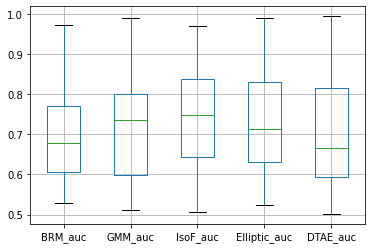

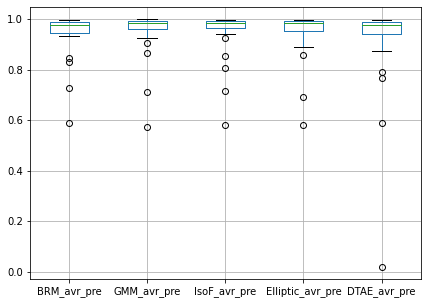

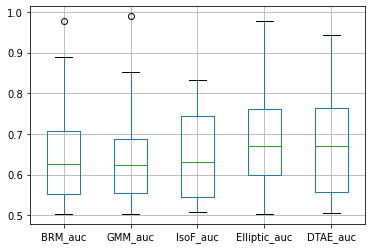

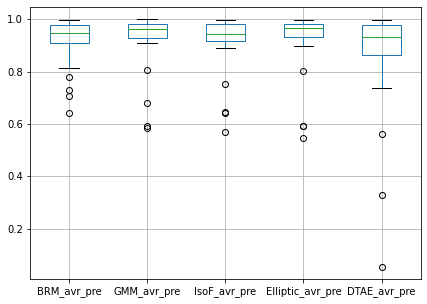

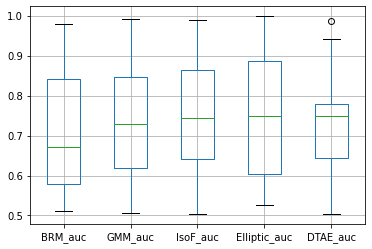

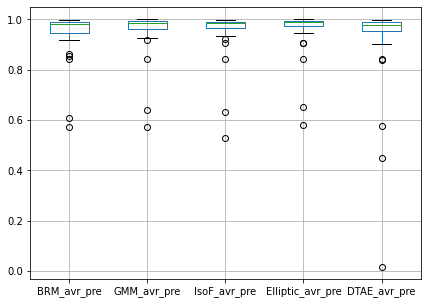

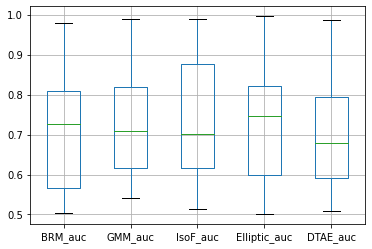

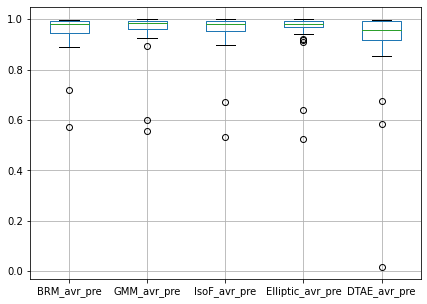

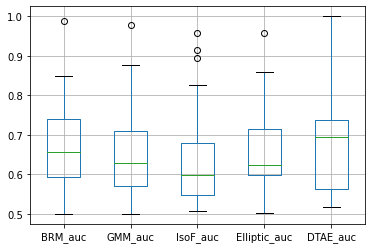

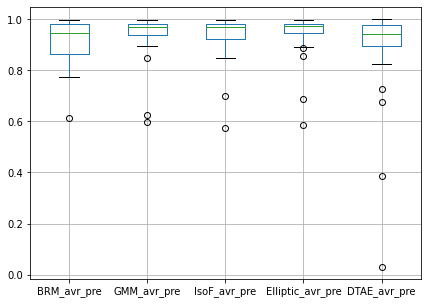

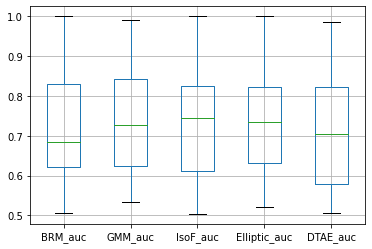

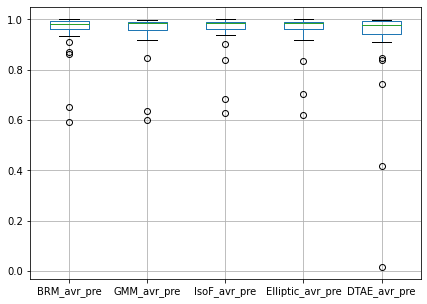

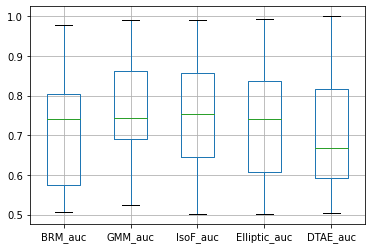

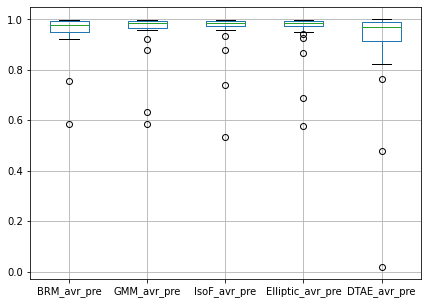

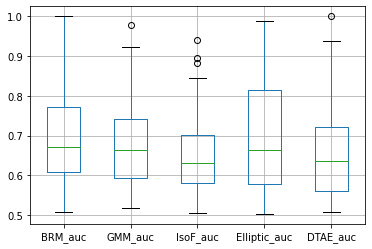

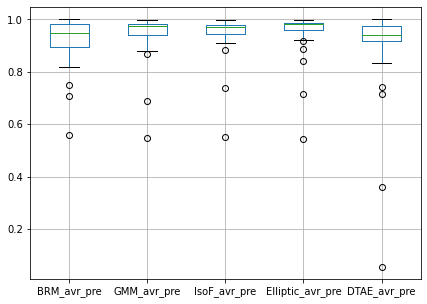

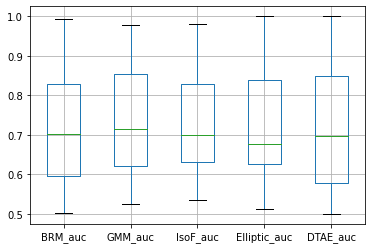

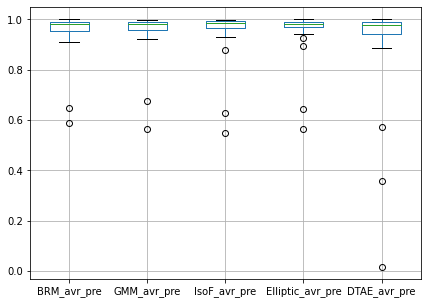

In [ ]:
#Boxplots for AUCs and Avr_Pre
df_list = [df_kmeans3, df_quantile3, df_uniform3, df_kmeans5, df_quantile5, df_uniform5,
           df_kmeans7, df_quantile7, df_uniform7]
names = ['kmeans3', 'quantile3', 'uniform3', 'kmeans5', 'quantile5', 'uniform5',
           'kmeans7', 'quantile7', 'uniform7']

auc_names = ['BRM_auc', 'GMM_auc', 'IsoF_auc', 'Elliptic_auc', 'DTAE_auc']

avrpre_names = ['BRM_avr_pre', 'GMM_avr_pre', 'IsoF_avr_pre', 'Elliptic_avr_pre', 'DTAE_avr_pre']

i=0
for df_model in df_list:
  plt.figure()
  df_model.boxplot(column = auc_names, figsize=(10,6))
  print()
  print('For {}:'.format(names[i]))
  print('Average AUC \n{}'.format(df_model[auc_names].mean()))
  print()
  print('Friedman Chisquare test for AUC \n{}'.format(stats.friedmanchisquare(df_model.BRM_auc.values, df_model.GMM_auc.values, df_model.IsoF_auc.values,
                                                                                          df_model.Elliptic_auc.values, df_model.DTAE_auc.values)))
  print()
  plt.savefig("Boxplot_{}_AUC".format(names[i]))
  print('Posthoc Friedman Test values for AUC with {}'.format(names[i]))
  display(sp.posthoc_nemenyi_friedman(df_model[auc_names]))

  plt.figure(figsize=(7,5))
  df_model.boxplot(column = avrpre_names, figsize=(10,6))
  
  print('Average Precision \n{}'.format(df_model[avrpre_names].mean()))
  print()
  print('Friedman Chisquare test for average precision \n{}'.format(stats.friedmanchisquare(df_model.BRM_avr_pre.values, df_model.GMM_avr_pre.values, 
                                                                                          df_model.IsoF_avr_pre.values, df_model.Elliptic_avr_pre.values,
                                                                                          df_model.DTAE_avr_pre.values)))
  print()
  plt.savefig("Boxplot_{}_AvrPre".format(names[i]))
  print('Posthoc Friedman Test values for average precision with {}'.format(names[i]))
  display(sp.posthoc_nemenyi_friedman(df_model[avrpre_names]))

  i+=1


## Implementation with Kmeans7 and DTAE with unsupervised classifier (Kmeans clustering).

In [5]:
from weka.core import jvm
#jvm.stop()
jvm.start(packages=True)

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/usr/local/lib/python3.7/dist-packages/javabridge/jars/rhino-1.7R4.jar', '/usr/local/lib/python3.7/dist-packages/javabridge/jars/runnablequeue.jar', '/usr/local/lib/python3.7/dist-packages/javabridge/jars/cpython.jar', '/usr/local/lib/python3.7/dist-packages/weka/lib/weka.jar', '/usr/local/lib/python3.7/dist-packages/weka/lib/python-weka-wrapper.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support enabled


In [7]:
df_uns = main(7, 'kmeans', False)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-3-4-6_vs_5/ecoli-0-3-4-6_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-3-4-6_vs_5/ecoli-0-3-4-6_vs_5-5-1tst.arff
ecoli-0-3-4-6_vs_5
Dataset number: 1


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_cente

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1-4-7_vs_2-3-5-6/ecoli-0-1-4-7_vs_2-3-5-6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1-4-7_vs_2-3-5-6/ecoli-0-1-4-7_vs_2-3-5-6-5-1tst.arff
ecoli-0-1-4-7_vs_2-3-5-6
Dataset number: 2


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_cente

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-2-3-4_vs_5/ecoli-0-2-3-4_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-2-3-4_vs_5/ecoli-0-2-3-4_vs_5-5-1tst.arff
ecoli-0-2-3-4_vs_5
Dataset number: 3


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/shuttle-2_vs_5/shuttle-2_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/shuttle-2_vs_5/shuttle-2_vs_5-5-1tst.arff
shuttle-2_vs_5
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-3-4_vs_5/ecoli-0-3-4_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-3-4_vs_5/ecoli-0-3-4_vs_5-5-1tst.arff
ecoli-0-3-4_vs_5
Dataset number: 4


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass4/glass4-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass4/glass4-5-1tst.arff
glass4
Dataset number: 5


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass2/glass2-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass2/glass2-5-1tst.arff
glass2
Dataset number: 6


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6-7/winequality-red-8_vs_6-7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6-7/winequality-red-8_vs_6-7-5-1tst.arff
winequality-red-8_vs_6-7
Dataset number: 7


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-4-6_vs_5/ecoli-0-4-6_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-4-6_vs_5/ecoli-0-4-6_vs_5-5-1tst.arff
ecoli-0-4-6_vs_5
Dataset number: 8


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_cente

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/cleveland-0_vs_4/cleveland-0_vs_4-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/cleveland-0_vs_4/cleveland-0_vs_4-5-1tst.arff
cleveland-0_vs_4
Dataset number: 9


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass1/glass1-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass1/glass1-5-1tst.arff
glass1
Dataset number: 10


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6/winequality-red-8_vs_6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/winequality-red-8_vs_6/winequality-red-8_vs_6-5-1tst.arff
winequality-red-8_vs_6
Dataset number: 11


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1_vs_7/yeast-1_vs_7-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-1_vs_7/yeast-1_vs_7-5-1tst.arff
yeast-1_vs_7
Dataset number: 12


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_cente

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/lymphography-normal-fibrosis/lymphography-normal-fibrosis-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/lymphography-normal-fibrosis/lymphography-normal-fibrosis-5-1tst.arff
lymphography-normal-fibrosis
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-20_vs_8-9-10/abalone-20_vs_8-9-10-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-20_vs_8-9-10/abalone-20_vs_8-9-10-5-1tst.arff
abalone-20_vs_8-9-10
Dataset number: 13


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-50.985744240207524 > -51.191492530692173). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-51.225301230449332 > -51.228355195343923). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-50.727570498348051 > -51.212107587037949). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/p

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/shuttle-c2-vs-c4/shuttle-c2-vs-c4-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/shuttle-c2-vs-c4/shuttle-c2-vs-c4-5-1tst.arff
shuttle-c2-vs-c4
Dataset number: 14


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-19.661166439757544 > -48.367618508541668). You may want to try with a higher value of support_fraction (current value: 0.543).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-19.449943178214646 > -50.322904924985693). You may want to try with a higher value of support_fraction (current value: 0.543).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct c

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast5/yeast5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast5/yeast5-5-1tst.arff
yeast5
Dataset number: 15


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_cente

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli4/ecoli4-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli4/ecoli4-5-1tst.arff
ecoli4
Dataset number: 16


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/shuttle-6_vs_2-3/shuttle-6_vs_2-3-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/shuttle-6_vs_2-3/shuttle-6_vs_2-3-5-1tst.arff
shuttle-6_vs_2-3
Dataset number: 17


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_cente

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-0-2-5-6_vs_3-7-8-9/yeast-0-2-5-6_vs_3-7-8-9-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/yeast-0-2-5-6_vs_3-7-8-9/yeast-0-2-5-6_vs_3-7-8-9-5-1tst.arff
yeast-0-2-5-6_vs_3-7-8-9
Dataset number: 18


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_cente

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8_vs_6/poker-8_vs_6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8_vs_6/poker-8_vs_6-5-1tst.arff
poker-8_vs_6
Dataset number: 19


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/zoo-3/zoo-3-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/zoo-3/zoo-3-5-1tst.arff
zoo-3
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/wisconsinImb/wisconsinImb-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/wisconsinImb/wisconsinImb-5-1tst.arff
wisconsinImb
Dataset number: 20


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-6_vs_5/glass-0-6_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-6_vs_5/glass-0-6_vs_5-5-1tst.arff
glass-0-6_vs_5
Dataset number: 21


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/iris0/iris0-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/iris0/iris0-5-1tst.arff
iris0
Dataset number: 22


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-3_vs_11/abalone-3_vs_11-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-3_vs_11/abalone-3_vs_11-5-1tst.arff
abalone-3_vs_11
Dataset number: 23


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-50.551287378308061 > -53.275032091358796). You may want to try with a higher value of support_fraction (current value: 0.512).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:201: UserWarning: Feature 2 is constant and will be replaced with 0.
  "Feature %d is constant and will be replaced with 0." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing t

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/segment0/segment0-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/segment0/segment0-5-1tst.arff
segment0
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1-4-7_vs_5-6/ecoli-0-1-4-7_vs_5-6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1-4-7_vs_5-6/ecoli-0-1-4-7_vs_5-6-5-1tst.arff
ecoli-0-1-4-7_vs_5-6
Dataset number: 24


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-21_vs_8/abalone-21_vs_8-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-21_vs_8/abalone-21_vs_8-5-1tst.arff
abalone-21_vs_8
Dataset number: 25


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-51.634805338326409 > -54.133390441690260). You may want to try with a higher value of support_fraction (current value: 0.509).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-51.403705663544798 > -52.097547932747148). You may want to try with a higher value of support_fraction (current value: 0.509).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-51.893752842488290 > -52.884465860560937). You may want to try with a higher value of support_fraction (current value: 0.509).
  RuntimeWarning,
/usr/local/lib/p

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass6/glass6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass6/glass6-5-1tst.arff
glass6
Dataset number: 26


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_cente

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8-9_vs_5/poker-8-9_vs_5-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8-9_vs_5/poker-8-9_vs_5-5-1tst.arff
poker-8-9_vs_5
Dataset number: 27


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:739: UserWarning: The covariance matrix associated to your dataset is not full rank
  "The covariance matrix associated to your dataset is not full rank"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-1-6_vs_2/glass-0-1-6_vs_2-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-1-6_vs_2/glass-0-1-6_vs_2-5-1tst.arff
glass-0-1-6_vs_2
Dataset number: 28


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:239: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:225: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_cente

/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8-9_vs_6/poker-8-9_vs_6-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/poker-8-9_vs_6/poker-8-9_vs_6-5-1tst.arff
poker-8-9_vs_6
Dataset number: 29


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-1-4-6_vs_2/glass-0-1-4-6_vs_2-5-1tra.arff
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/glass-0-1-4-6_vs_2/glass-0-1-4-6_vs_2-5-1tst.arff
glass-0-1-4-6_vs_2
Dataset number: 30


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [8]:
df_uns.to_csv('discret_uns_kmeans7.csv')


For kmeans7 and unsupervised DTAE:
Average AUC 
BRM_auc         0.722006
GMM_auc         0.744167
IsoF_auc        0.750722
Elliptic_auc    0.759125
DTAE_auc        0.717665
dtype: float64

Friedman Chisquare test for AUC 
FriedmanchisquareResult(statistic=7.165275459098586, pvalue=0.1274077158481084)

Posthoc Friedman Test values for AUC with kmeans7 and unsupervised DTAE


,BRM_auc,GMM_auc,IsoF_auc,Elliptic_auc,DTAE_auc
BRM_auc,1.000000,0.900000,0.401405,0.451814,0.900000
GMM_auc,0.900000,1.000000,0.548090,0.594427,0.900000
IsoF_auc,0.401405,0.548090,1.000000,0.900000,0.286112
Elliptic_auc,0.451814,0.594427,0.900000,1.000000,0.329183
DTAE_auc,0.900000,0.900000,0.286112,0.329183,1.000000



For kmeans7 and unsupervised DTAE:
Average Precision 
BRM_avr_pre         0.943444
GMM_avr_pre         0.954084
IsoF_avr_pre        0.955583
Elliptic_avr_pre    0.956828
DTAE_avr_pre        0.937744
dtype: float64

Friedman Chisquare test for Average Precision 
FriedmanchisquareResult(statistic=13.840000000000032, pvalue=0.007823613129007227)

Posthoc Friedman Test values for Average Precision with kmeans7 and unsupervised DTAE


,BRM_avr_pre,GMM_avr_pre,IsoF_avr_pre,Elliptic_avr_pre,DTAE_avr_pre
BRM_avr_pre,1.000000,0.900000,0.849291,0.246189,0.617596
GMM_avr_pre,0.900000,1.000000,0.617596,0.102437,0.849291
IsoF_avr_pre,0.849291,0.617596,1.000000,0.802950,0.124437
Elliptic_avr_pre,0.246189,0.102437,0.802950,1.000000,0.005471
DTAE_avr_pre,0.617596,0.849291,0.124437,0.005471,1.000000


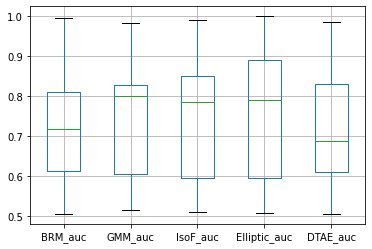

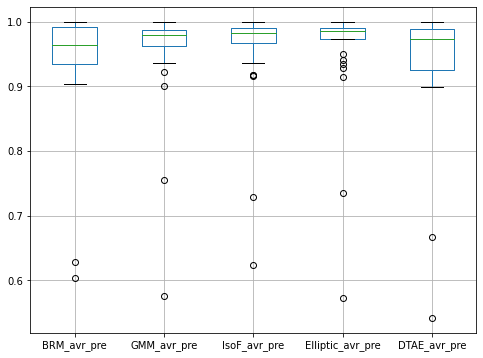

In [15]:
auc_names = ['BRM_auc', 'GMM_auc', 'IsoF_auc', 'Elliptic_auc', 'DTAE_auc']

avrpre_names = ['BRM_avr_pre', 'GMM_avr_pre', 'IsoF_avr_pre', 'Elliptic_avr_pre', 'DTAE_avr_pre']

plt.figure()

df_uns.boxplot(column = auc_names, figsize=(10,6))
print()
print('For kmeans7 and unsupervised DTAE:')
print('Average AUC \n{}'.format(df_uns[auc_names].mean()))
print()
print('Friedman Chisquare test for AUC \n{}'.format(stats.friedmanchisquare(df_uns.BRM_auc.values, df_uns.GMM_auc.values, df_uns.IsoF_auc.values,
                                                                                        df_uns.Elliptic_auc.values, df_uns.DTAE_auc.values)))
print()
plt.savefig("Boxplot_AUC_uns")
print('Posthoc Friedman Test values for AUC with kmeans7 and unsupervised DTAE')
display(sp.posthoc_nemenyi_friedman(df_uns[auc_names]))

plt.figure(figsize=(8,6))

df_uns.boxplot(column = avrpre_names, figsize=(10,6))
print()
print('For kmeans7 and unsupervised DTAE:')
print('Average Precision \n{}'.format(df_uns[avrpre_names].mean()))
print()
print('Friedman Chisquare test for Average Precision \n{}'.format(stats.friedmanchisquare(df_uns.BRM_avr_pre.values, df_uns.GMM_avr_pre.values, df_uns.IsoF_avr_pre.values,
                                                                                        df_uns.Elliptic_avr_pre.values, df_uns.DTAE_avr_pre.values)))
print()
plt.savefig("Boxplot_AvrPre_uns")
print('Posthoc Friedman Test values for Average Precision with kmeans7 and unsupervised DTAE')
display(sp.posthoc_nemenyi_friedman(df_uns[avrpre_names]))

## Temporal

In [ ]:
!python /content/DTAE/main.py --training_data /content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-17_vs_7-8-9-10/abalone-17_vs_7-8-9-10-5-1tra.arff --testing_data /content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/abalone-17_vs_7-8-9-10/abalone-17_vs_7-8-9-10-5-1tst.arff --outfile my_result.json --rand_init

In [ ]:
jvm.stop()